Text(0, 0.5, 'Cycle life')

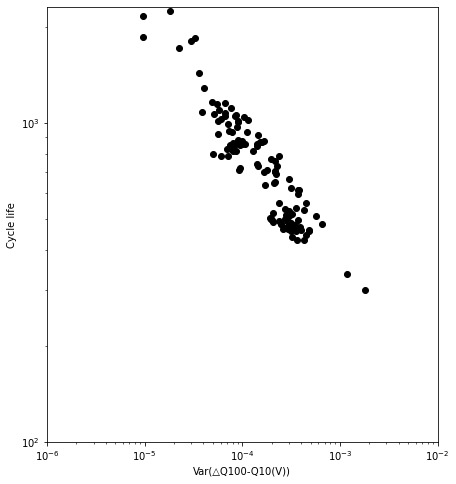

In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

X=[]
Y=[]

for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var,cycle=np.var(diff),bat_dict[j]['cycle_life'].tolist()
    X.append(var)
    Y.append(cycle[0][0])
    
plt.figure(figsize=(7,8))
plt.scatter(X,Y,color='black')
plt.xscale('log')
plt.yscale('log')
plt.axis([10**(-6),10**(-2),100,2300])
plt.xlabel('Var(△Q100-Q10(V))')
plt.ylabel('Cycle life')

In [2]:
cycle_test=bat_dict['b1c0']['cycle_life'].tolist()
cycle_test[0][0]

1852.0

In [3]:
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat);

In [4]:
np.random.seed(42)
threshold = 550

In [5]:
imax=150
jmax=60

def i_j_make():
    i_=[]
    j_=[]
    for i in range(2,imax+1): # 
        for j in range(1,jmax+1): # j
            if i<=j:
                continue
            i_.append(i)
            j_.append(j)
    return i_,j_

In [6]:
i_, j_ =i_j_make()

In [7]:
test_data=[]
train_data=[]

test_label=[]
train_label=[]

sec_data=[]
sec_label=[]
for i,j in enumerate(bat_dict.keys()):
    if j=='b2c1':
        continue
    if j=='b3c16':
        continue
    if j=='b3c17':
        continue
    if j=='b3c42':
        continue
    if j=='b3c43':
        continue
    if i in test_ind :
        test_data.append(j)
        cycle_test=bat_dict[j]['cycle_life'].tolist()
        test_label.append(cycle_test[0][0])
        
    if i in train_ind :
        train_data.append(j)
        cycle_train=bat_dict[j]['cycle_life'].tolist()
        train_label.append(cycle_train[0][0])
            
            
    if i in secondary_test_ind:
        sec_data.append(j)
        cycle_sec=bat_dict[j]['cycle_life'].tolist()
        sec_label.append(cycle_sec[0][0])

In [8]:
test_data=np.array(test_data)
train_data=np.array(train_data)
test_label=np.array(test_label)
train_label=np.array(train_label)
sec_label=np.array(sec_label)
sec_data=np.array(sec_data)

In [9]:
train_data.shape, train_label.shape, test_data.shape, test_label.shape, sec_data.shape, sec_label.shape

((41,), (41,), (42,), (42,), (36,), (36,))

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def Logistic_RMSE(X,Y,boot_trainX,boot_trainY,boot_testX,boot_testY): #학습은 train data 로 진행 하고 predict는 랜덤 데이터 얻기
    Log_reg = LinearRegression()
    x=X.reshape(-1,1)
    Log_reg.fit(x,Y)
    train_X=boot_trainX.reshape(-1,1)
    test_X=boot_testX.reshape(-1,1)
    
    pred_train=Log_reg.predict(train_X.reshape(-1,1))
    pred_test=Log_reg.predict(test_X.reshape(-1,1))

    RMSE_train=mean_squared_error(boot_trainY,pred_train, squared=False)
    RMSE_test=mean_squared_error(boot_testY,pred_test, squared=False)

    
    return RMSE_train, RMSE_test



In [11]:
#train(i*j) AUC 구하기
mx_train=np.zeros((jmax+1,imax+1))
mx_test=np.zeros((jmax+1,imax+1))
for i,j in zip(i_,j_):
    var_=np.array([])
    var_test_=np.array([])
    var_sec_=np.array([])
    for k in train_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_=np.hstack([var_,np.var(diff)])
    for k in test_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_test_=np.hstack([var_test_,np.var(diff)])
    for k in sec_data:
        diff=bat_dict[k]['cycles']['{}'.format(i)]['Qdlin']- bat_dict[k]['cycles']['{}'.format(j)]['Qdlin']
        var_sec_=np.hstack([var_sec_,np.var(diff)])
    print(var_.shape,var_test_.shape,var_sec_.shape)
    

    
    #데이터 정규화(표준화, Z-scoring ,) , mean, std 구하기 뒤에 rmse 에 사용할 것.
    scaler = StandardScaler() 
    #train
    var_mean=np.mean(np.log(var_))
    var_std=np.std(np.log(var_))
    print('mean',var_mean,'std',var_std)
    var = scaler.fit_transform(np.log(var_).reshape(-1,1))
    var_test = scaler.transform(np.log(var_test_).reshape(-1,1))
    var_sec = scaler.transform(np.log(var_sec_).reshape(-1,1))   



    boot_select_train=len(var)
    boot_select_test=len(var_test)
    
    boot_sample=20
    
    train_range= range(0,boot_select_train) # 0~40 숫자중 41번 랜덤 선택하도록 한 후 배열에 이 숫자를 적용.
    test_range= range(0,boot_select_test)
    
    rmse_train=[]
    rmse_test=[]
    
    for _ in range(boot_sample):
        np.random.seed(9)
        sample_n=np.random.choice(train_range ,size=boot_select_train)
        sample_test=np.random.choice(test_range ,size=boot_select_test)
        random_trainX=np.array([])
        random_trainY=np.array([])
        random_testX=np.array([])
        random_testY=np.array([])
        for n in sample_n:
            random_trainX=np.hstack([random_trainX,np.array(var[n])])
            random_trainY=np.hstack([random_trainY,np.array([train_label[n]])])
        for n in sample_test:
            random_testX=np.hstack([random_testX,np.array(var_test[n])])
            random_testY=np.hstack([random_testY,np.array([test_label[n]])])
        RMSE_train, RMSE_test =Logistic_RMSE(var,train_label,random_trainX,random_trainY,random_testX,random_testY)
        rmse_train.append(RMSE_train)
        rmse_test.append(RMSE_test)
        
    rmse_train_cycle=np.mean(rmse_train)
    rmse_test_cycle=np.mean(rmse_test)

    print('i={},j={}   RMSE_train= '.format(i,j),rmse_train_cycle)
    print('i={},j={}   RMSE_test= '.format(i,j),rmse_test_cycle)
    print('\n')
    mx_train[j,i]= rmse_train_cycle
    mx_test[j,i]= rmse_test_cycle


(41,) (42,) (36,)
mean -12.99206075097377 std 1.7829928090282348
i=2,j=1   RMSE_train=  381.18008960127344
i=2,j=1   RMSE_test=  453.7367427389139


(41,) (42,) (36,)
mean -12.28316889759099 std 1.6885065160408774
i=3,j=1   RMSE_train=  394.941484011499
i=3,j=1   RMSE_test=  478.482251618347


(41,) (42,) (36,)
mean -13.824281509405603 std 1.4482326550769522
i=3,j=2   RMSE_train=  406.4891479576152
i=3,j=2   RMSE_test=  492.995739553608


(41,) (42,) (36,)
mean -12.253164981318871 std 0.8129985920852422
i=4,j=1   RMSE_train=  393.6910020026719
i=4,j=1   RMSE_test=  467.25787797133154


(41,) (42,) (36,)
mean -13.00111513895064 std 1.2347983102887559
i=4,j=2   RMSE_train=  392.51953134177046
i=4,j=2   RMSE_test=  462.48261805104113


(41,) (42,) (36,)
mean -13.149058136796047 std 1.7136532137585527
i=4,j=3   RMSE_train=  380.6534201438898
i=4,j=3   RMSE_test=  468.4136750609379


(41,) (42,) (36,)
mean -11.81405670323324 std 1.2748446743483928
i=5,j=1   RMSE_train=  411.1773328450312
i=

(41,) (42,) (36,)
mean -11.90053450689575 std 2.8740638529362195
i=12,j=3   RMSE_train=  396.73731668691204
i=12,j=3   RMSE_test=  482.38514971279466


(41,) (42,) (36,)
mean -12.214846352424255 std 3.1445583776960193
i=12,j=4   RMSE_train=  397.1517711109908
i=12,j=4   RMSE_test=  483.55100207390217


(41,) (42,) (36,)
mean -12.313458695340806 std 3.0161781280097233
i=12,j=5   RMSE_train=  402.35817989506165
i=12,j=5   RMSE_test=  489.16251458096156


(41,) (42,) (36,)
mean -12.322217936098813 std 3.041142909845121
i=12,j=6   RMSE_train=  400.8780858975917
i=12,j=6   RMSE_test=  488.3538187108419


(41,) (42,) (36,)
mean -12.384563306530945 std 3.265743218465759
i=12,j=7   RMSE_train=  402.57831472015886
i=12,j=7   RMSE_test=  488.3661516196057


(41,) (42,) (36,)
mean -12.784508850824405 std 3.2320855909195574
i=12,j=8   RMSE_train=  399.08877434916127
i=12,j=8   RMSE_test=  490.5426496105788


(41,) (42,) (36,)
mean -12.813817371620267 std 3.3120358326606083
i=12,j=9   RMSE_train=  

i=16,j=7   RMSE_train=  416.6425968612195
i=16,j=7   RMSE_test=  479.1333837642689


(41,) (42,) (36,)
mean -13.077167563580073 std 0.8919007594058975
i=16,j=8   RMSE_train=  406.9281535718492
i=16,j=8   RMSE_test=  487.0807681826453


(41,) (42,) (36,)
mean -12.860812807849173 std 1.0584140645804827
i=16,j=9   RMSE_train=  410.5045352206995
i=16,j=9   RMSE_test=  487.8441669574434


(41,) (42,) (36,)
mean -13.028516006182283 std 1.0554261590119995
i=16,j=10   RMSE_train=  402.42492425778374
i=16,j=10   RMSE_test=  490.06062232809745


(41,) (42,) (36,)
mean -12.960029739755823 std 3.099212732493249
i=16,j=11   RMSE_train=  337.3120970667626
i=16,j=11   RMSE_test=  415.7067180790879


(41,) (42,) (36,)
mean -12.63261410193749 std 3.065176900939285
i=16,j=12   RMSE_train=  402.5479607023751
i=16,j=12   RMSE_test=  490.96387297024023


(41,) (42,) (36,)
mean -14.136523006635382 std 1.2095047850532088
i=16,j=13   RMSE_train=  391.3082986869539
i=16,j=13   RMSE_test=  477.73597017215496




i=19,j=14   RMSE_train=  405.5557634154837
i=19,j=14   RMSE_test=  492.2012493293144


(41,) (42,) (36,)
mean -13.403422895268848 std 1.5507425232610768
i=19,j=15   RMSE_train=  381.39429887273025
i=19,j=15   RMSE_test=  483.6847025281405


(41,) (42,) (36,)
mean -14.68116339002059 std 1.0735421543222314
i=19,j=16   RMSE_train=  413.5023453614819
i=19,j=16   RMSE_test=  500.3688336942779


(41,) (42,) (36,)
mean -14.395460921869926 std 1.4372388780964105
i=19,j=17   RMSE_train=  414.7948786749058
i=19,j=17   RMSE_test=  500.9574830997282


(41,) (42,) (36,)
mean -13.817407426159702 std 2.391021575172888
i=19,j=18   RMSE_train=  375.68504834785034
i=19,j=18   RMSE_test=  458.0069051628856


(41,) (42,) (36,)
mean -11.34514821782418 std 1.2769212977706874
i=20,j=1   RMSE_train=  383.4223105470083
i=20,j=1   RMSE_test=  471.73493198924353


(41,) (42,) (36,)
mean -12.013843694925946 std 0.779947207732303
i=20,j=2   RMSE_train=  379.88968782474626
i=20,j=2   RMSE_test=  470.4643936988873



i=22,j=12   RMSE_train=  400.6643144147346
i=22,j=12   RMSE_test=  487.7908707131813


(41,) (42,) (36,)
mean -12.87930981371875 std 0.7469335502895359
i=22,j=13   RMSE_train=  344.63344772896545
i=22,j=13   RMSE_test=  455.9135847430049


(41,) (42,) (36,)
mean -12.731983356006818 std 0.971643944863518
i=22,j=14   RMSE_train=  414.939248908482
i=22,j=14   RMSE_test=  486.49908576104224


(41,) (42,) (36,)
mean -12.798099327124563 std 1.4406341836447614
i=22,j=15   RMSE_train=  393.70837468886407
i=22,j=15   RMSE_test=  495.15159581490104


(41,) (42,) (36,)
mean -13.455645560435784 std 1.004770135032696
i=22,j=16   RMSE_train=  411.51478690119967
i=22,j=16   RMSE_test=  494.3813104857321


(41,) (42,) (36,)
mean -13.154100292995045 std 1.511894045167363
i=22,j=17   RMSE_train=  409.41189364944876
i=22,j=17   RMSE_test=  495.48658677101423


(41,) (42,) (36,)
mean -13.26538818754235 std 1.8829293479487585
i=22,j=18   RMSE_train=  396.1592410818903
i=22,j=18   RMSE_test=  502.4117685065

(41,) (42,) (36,)
mean -11.298522033352379 std 1.0093894210926768
i=25,j=1   RMSE_train=  411.06130584641977
i=25,j=1   RMSE_test=  465.6654903083048


(41,) (42,) (36,)
mean -11.760820978852605 std 0.669161317842314
i=25,j=2   RMSE_train=  403.86202319957096
i=25,j=2   RMSE_test=  460.15084767677956


(41,) (42,) (36,)
mean -11.777318326053782 std 0.7511827443730134
i=25,j=3   RMSE_train=  409.40087193778646
i=25,j=3   RMSE_test=  452.11888037482333


(41,) (42,) (36,)
mean -11.617707437850694 std 0.8623703970386378
i=25,j=4   RMSE_train=  364.1120758161939
i=25,j=4   RMSE_test=  402.0822026623317


(41,) (42,) (36,)
mean -11.815042141149455 std 0.6301198566024269
i=25,j=5   RMSE_train=  388.0966589426236
i=25,j=5   RMSE_test=  426.2329951813143


(41,) (42,) (36,)
mean -11.767537222520525 std 0.7099714039750294
i=25,j=6   RMSE_train=  363.7411758907464
i=25,j=6   RMSE_test=  369.4006039314676


(41,) (42,) (36,)
mean -11.709086250235666 std 0.8638482403602783
i=25,j=7   RMSE_train=  

i=27,j=5   RMSE_train=  318.3984030733652
i=27,j=5   RMSE_test=  329.0207792323166


(41,) (42,) (36,)
mean -11.31871647470381 std 1.0166345778541228
i=27,j=6   RMSE_train=  342.5505597531443
i=27,j=6   RMSE_test=  364.649420750751


(41,) (42,) (36,)
mean -11.808762249096318 std 0.696431335781192
i=27,j=7   RMSE_train=  353.49837557182
i=27,j=7   RMSE_test=  373.2096179784645


(41,) (42,) (36,)
mean -11.59622253503512 std 0.9331108176365421
i=27,j=8   RMSE_train=  302.69786265226867
i=27,j=8   RMSE_test=  282.87838557451875


(41,) (42,) (36,)
mean -11.58598196545618 std 1.0733414294842412
i=27,j=9   RMSE_train=  311.9182811544107
i=27,j=9   RMSE_test=  345.37622011543283


(41,) (42,) (36,)
mean -11.906990535211742 std 0.6757795423365912
i=27,j=10   RMSE_train=  370.1648766690372
i=27,j=10   RMSE_test=  407.5594466043002


(41,) (42,) (36,)
mean -11.17299468172363 std 2.745810780092602
i=27,j=11   RMSE_train=  350.3633861720983
i=27,j=11   RMSE_test=  436.7130384615886


(41,) (42,)

i=29,j=6   RMSE_train=  339.87627560660815
i=29,j=6   RMSE_test=  387.9384732945212


(41,) (42,) (36,)
mean -11.332471054474931 std 0.9841372565889946
i=29,j=7   RMSE_train=  357.64368888009005
i=29,j=7   RMSE_test=  399.88927869549025


(41,) (42,) (36,)
mean -11.569793700511386 std 0.8013232548134902
i=29,j=8   RMSE_train=  326.7946148878284
i=29,j=8   RMSE_test=  360.8543297830008


(41,) (42,) (36,)
mean -11.62953506473306 std 0.7022414754209514
i=29,j=9   RMSE_train=  343.59273481168185
i=29,j=9   RMSE_test=  403.91465221244357


(41,) (42,) (36,)
mean -11.450684277867191 std 1.0387727991475684
i=29,j=10   RMSE_train=  317.7728133607303
i=29,j=10   RMSE_test=  361.5910386702406


(41,) (42,) (36,)
mean -11.029547980303391 std 2.7000920997501865
i=29,j=11   RMSE_train=  354.6180574320257
i=29,j=11   RMSE_test=  441.985891104884


(41,) (42,) (36,)
mean -11.157889081675702 std 2.6528592644740696
i=29,j=12   RMSE_train=  384.5341019094077
i=29,j=12   RMSE_test=  466.69305508735613



(41,) (42,) (36,)
mean -11.170772886727374 std 0.7203997234837749
i=31,j=5   RMSE_train=  304.1930328755212
i=31,j=5   RMSE_test=  353.7155710195146


(41,) (42,) (36,)
mean -11.110494592854803 std 0.8187601545875791
i=31,j=6   RMSE_train=  325.64358028051987
i=31,j=6   RMSE_test=  378.0978527019396


(41,) (42,) (36,)
mean -11.197391552299251 std 0.6879289788660091
i=31,j=7   RMSE_train=  327.3855998206098
i=31,j=7   RMSE_test=  377.12952124718595


(41,) (42,) (36,)
mean -11.340184995259571 std 0.7023593394617201
i=31,j=8   RMSE_train=  310.68528144871624
i=31,j=8   RMSE_test=  346.4337577067253


(41,) (42,) (36,)
mean -11.266097293765686 std 0.7976352136930893
i=31,j=9   RMSE_train=  337.7245696292457
i=31,j=9   RMSE_test=  383.9787519922294


(41,) (42,) (36,)
mean -11.42387646728971 std 0.7420048082105339
i=31,j=10   RMSE_train=  271.446768836143
i=31,j=10   RMSE_test=  332.26676757961263


(41,) (42,) (36,)
mean -11.004756463804007 std 2.6560535117207067
i=31,j=11   RMSE_train= 

i=32,j=29   RMSE_train=  326.80182020903874
i=32,j=29   RMSE_test=  425.7815650394447


(41,) (42,) (36,)
mean -13.674898616850161 std 2.0445148376556794
i=32,j=30   RMSE_train=  314.2613535019658
i=32,j=30   RMSE_test=  411.27327276145735


(41,) (42,) (36,)
mean -14.459774762549387 std 2.378048029085202
i=32,j=31   RMSE_train=  344.8362782555588
i=32,j=31   RMSE_test=  430.1298111715485


(41,) (42,) (36,)
mean -10.993759768160041 std 0.7414341692147697
i=33,j=1   RMSE_train=  321.2972350530584
i=33,j=1   RMSE_test=  390.95515683134903


(41,) (42,) (36,)
mean -11.025606865364937 std 0.816898654605706
i=33,j=2   RMSE_train=  296.66461165699036
i=33,j=2   RMSE_test=  358.3379779713589


(41,) (42,) (36,)
mean -10.892578518312622 std 0.9790847105718117
i=33,j=3   RMSE_train=  297.9542592106594
i=33,j=3   RMSE_test=  307.1173504809494


(41,) (42,) (36,)
mean -11.017941715056397 std 0.8607527612061776
i=33,j=4   RMSE_train=  254.57292070390145
i=33,j=4   RMSE_test=  329.89627507089637





(41,) (42,) (36,)
mean -11.982198707098126 std 1.0792710138851007
i=34,j=22   RMSE_train=  351.45267039182204
i=34,j=22   RMSE_test=  412.87751100708283


(41,) (42,) (36,)
mean -12.090345199851441 std 1.2239696123562798
i=34,j=23   RMSE_train=  358.24735569406243
i=34,j=23   RMSE_test=  407.1512165744371


(41,) (42,) (36,)
mean -12.236598030232058 std 1.4351639111450138
i=34,j=24   RMSE_train=  366.389038265269
i=34,j=24   RMSE_test=  427.1707486306647


(41,) (42,) (36,)
mean -12.256326167268428 std 1.423170283472963
i=34,j=25   RMSE_train=  380.84108687458263
i=34,j=25   RMSE_test=  438.9596332425273


(41,) (42,) (36,)
mean -12.232430067735852 std 1.640632454954635
i=34,j=26   RMSE_train=  363.67639072867564
i=34,j=26   RMSE_test=  439.44245848169174


(41,) (42,) (36,)
mean -12.67756480143212 std 1.4730738489751671
i=34,j=27   RMSE_train=  367.8046794956245
i=34,j=27   RMSE_test=  452.1130410494792


(41,) (42,) (36,)
mean -12.730908658571614 std 1.5530467536342412
i=34,j=28   

i=36,j=9   RMSE_train=  297.3665903978846
i=36,j=9   RMSE_test=  365.6063595131915


(41,) (42,) (36,)
mean -11.11256275360317 std 0.8615293400444316
i=36,j=10   RMSE_train=  178.83854145710248
i=36,j=10   RMSE_test=  267.52846763356945


(41,) (42,) (36,)
mean -10.578116485570641 std 2.5822783645502545
i=36,j=11   RMSE_train=  358.6249300395724
i=36,j=11   RMSE_test=  445.0206383329629


(41,) (42,) (36,)
mean -10.742690246165704 std 2.6096010294892307
i=36,j=12   RMSE_train=  374.96470335217697
i=36,j=12   RMSE_test=  467.55426877562905


(41,) (42,) (36,)
mean -11.262190589007758 std 0.7518192648406191
i=36,j=13   RMSE_train=  223.8561101482738
i=36,j=13   RMSE_test=  318.46120736677847


(41,) (42,) (36,)
mean -11.19392617550816 std 0.7971480911484047
i=36,j=14   RMSE_train=  259.9547677444527
i=36,j=14   RMSE_test=  320.92058801637387


(41,) (42,) (36,)
mean -11.381631318613564 std 0.9399405175103281
i=36,j=15   RMSE_train=  275.2771165900516
i=36,j=15   RMSE_test=  401.145530158


(41,) (42,) (36,)
mean -12.853795757858396 std 1.46007799448973
i=37,j=30   RMSE_train=  327.78008089936236
i=37,j=30   RMSE_test=  403.94051942010276


(41,) (42,) (36,)
mean -13.302316770971387 std 1.549235347807078
i=37,j=31   RMSE_train=  297.0300392645198
i=37,j=31   RMSE_test=  363.7521456910597


(41,) (42,) (36,)
mean -13.629519655426737 std 1.4043872362737413
i=37,j=32   RMSE_train=  329.77566373472854
i=37,j=32   RMSE_test=  402.45605253423776


(41,) (42,) (36,)
mean -13.352901961426152 std 1.9220143553472053
i=37,j=33   RMSE_train=  363.3883386434698
i=37,j=33   RMSE_test=  429.2800158365142


(41,) (42,) (36,)
mean -13.767565931835767 std 1.938554145531808
i=37,j=34   RMSE_train=  349.68018613570916
i=37,j=34   RMSE_test=  421.52146511381


(41,) (42,) (36,)
mean -13.915744530947698 std 2.3560070060302145
i=37,j=35   RMSE_train=  364.675113811765
i=37,j=35   RMSE_test=  442.2197109804282


(41,) (42,) (36,)
mean -14.352938846011831 std 2.1283734294735424
i=37,j=36   RMSE_

i=39,j=13   RMSE_train=  250.28158419859284
i=39,j=13   RMSE_test=  332.4354073935659


(41,) (42,) (36,)
mean -10.99043821423768 std 0.7136145426148947
i=39,j=14   RMSE_train=  271.8210302104113
i=39,j=14   RMSE_test=  303.42143813091786


(41,) (42,) (36,)
mean -11.07907715316236 std 0.8451172128410984
i=39,j=15   RMSE_train=  244.3396729591985
i=39,j=15   RMSE_test=  381.57944673560377


(41,) (42,) (36,)
mean -11.238745467571622 std 0.7420369901679688
i=39,j=16   RMSE_train=  277.7019375276207
i=39,j=16   RMSE_test=  329.1982244360788


(41,) (42,) (36,)
mean -11.134531954118252 std 0.8143188633409397
i=39,j=17   RMSE_train=  264.03293666598097
i=39,j=17   RMSE_test=  342.6898102202288


(41,) (42,) (36,)
mean -11.317084846135016 std 0.9316541071225741
i=39,j=18   RMSE_train=  309.5386509382322
i=39,j=18   RMSE_test=  402.24629787102015


(41,) (42,) (36,)
mean -11.433119316793546 std 0.7834566545291282
i=39,j=19   RMSE_train=  277.7494081503163
i=39,j=19   RMSE_test=  355.76034198

i=40,j=32   RMSE_train=  307.61654143571803
i=40,j=32   RMSE_test=  367.2137696712447


(41,) (42,) (36,)
mean -12.932947227632864 std 1.3826113473100092
i=40,j=33   RMSE_train=  264.5178890909338
i=40,j=33   RMSE_test=  333.696042656106


(41,) (42,) (36,)
mean -12.47646568462627 std 1.5879596507489169
i=40,j=34   RMSE_train=  338.57093222063185
i=40,j=34   RMSE_test=  401.57538272066466


(41,) (42,) (36,)
mean -12.74090138829928 std 1.656065122079864
i=40,j=35   RMSE_train=  364.3508891783325
i=40,j=35   RMSE_test=  423.0277244931484


(41,) (42,) (36,)
mean -13.213923107028325 std 1.3602575782553497
i=40,j=36   RMSE_train=  383.747037098983
i=40,j=36   RMSE_test=  445.32949695411105


(41,) (42,) (36,)
mean -12.990024864926854 std 1.7820001958297897
i=40,j=37   RMSE_train=  357.24242289674385
i=40,j=37   RMSE_test=  414.95319986408066


(41,) (42,) (36,)
mean -13.405491096801816 std 2.1068907837210777
i=40,j=38   RMSE_train=  361.0556835306845
i=40,j=38   RMSE_test=  440.9895245842

(41,) (42,) (36,)
mean -10.556498136119863 std 0.9740862176867566
i=42,j=9   RMSE_train=  180.89015034675518
i=42,j=9   RMSE_test=  224.6879307367745


(41,) (42,) (36,)
mean -10.626034944086292 std 0.6822255176287478
i=42,j=10   RMSE_train=  254.62734173709947
i=42,j=10   RMSE_test=  269.1920418357851


(41,) (42,) (36,)
mean -10.114273701677387 std 2.5024252505486957
i=42,j=11   RMSE_train=  356.8108423568571
i=42,j=11   RMSE_test=  445.79160474842695


(41,) (42,) (36,)
mean -10.268358183293108 std 2.5012322891682834
i=42,j=12   RMSE_train=  384.48708202062863
i=42,j=12   RMSE_test=  466.98232805490954


(41,) (42,) (36,)
mean -10.76902982894415 std 0.6886455241564047
i=42,j=13   RMSE_train=  242.13873659635888
i=42,j=13   RMSE_test=  287.39953590567825


(41,) (42,) (36,)
mean -10.668443875226362 std 0.665365435714722
i=42,j=14   RMSE_train=  299.34961124726544
i=42,j=14   RMSE_test=  312.4786231551287


(41,) (42,) (36,)
mean -10.806987212128583 std 0.7893281467178777
i=42,j=15   

(41,) (42,) (36,)
mean -11.344503038131867 std 0.8242366587819505
i=43,j=22   RMSE_train=  272.6129541492246
i=43,j=22   RMSE_test=  334.5817358656276


(41,) (42,) (36,)
mean -11.465050929135193 std 0.8402777859162319
i=43,j=23   RMSE_train=  315.88660537999044
i=43,j=23   RMSE_test=  377.3261196085201


(41,) (42,) (36,)
mean -11.340579398633524 std 1.0020109144492921
i=43,j=24   RMSE_train=  344.7322942066961
i=43,j=24   RMSE_test=  399.07814080698813


(41,) (42,) (36,)
mean -11.541901246457579 std 0.8405041162213898
i=43,j=25   RMSE_train=  330.7048044814382
i=43,j=25   RMSE_test=  406.8979723109699


(41,) (42,) (36,)
mean -11.459604446521032 std 0.917107118875729
i=43,j=26   RMSE_train=  287.8639513695497
i=43,j=26   RMSE_test=  365.11937508692915


(41,) (42,) (36,)
mean -11.662039512079831 std 0.9464437292991327
i=43,j=27   RMSE_train=  296.73437232494996
i=43,j=27   RMSE_test=  346.84499939486403


(41,) (42,) (36,)
mean -11.804659485610976 std 0.755712087083275
i=43,j=28   R

i=44,j=34   RMSE_train=  353.9456469543808
i=44,j=34   RMSE_test=  394.6197457372645


(41,) (42,) (36,)
mean -12.492712543973608 std 0.9967630119563256
i=44,j=35   RMSE_train=  374.9846054095648
i=44,j=35   RMSE_test=  438.9787893574914


(41,) (42,) (36,)
mean -12.270840691788695 std 1.2061953291913698
i=44,j=36   RMSE_train=  373.83875968318745
i=44,j=36   RMSE_test=  442.5097642065831


(41,) (42,) (36,)
mean -12.153350252614722 std 1.574891485784364
i=44,j=37   RMSE_train=  359.4508081348239
i=44,j=37   RMSE_test=  406.62177753493313


(41,) (42,) (36,)
mean -12.649419128291207 std 1.338177036830254
i=44,j=38   RMSE_train=  377.24965501009103
i=44,j=38   RMSE_test=  449.3716608109341


(41,) (42,) (36,)
mean -12.74892143063566 std 1.634309856643772
i=44,j=39   RMSE_train=  337.6799564368295
i=44,j=39   RMSE_test=  403.1465637101925


(41,) (42,) (36,)
mean -12.75054213136665 std 1.9610107620315844
i=44,j=40   RMSE_train=  347.53635596070944
i=44,j=40   RMSE_test=  423.393938135979

(41,) (42,) (36,)
mean -10.36447161725298 std 0.8581008999339913
i=46,j=2   RMSE_train=  250.76644981398863
i=46,j=2   RMSE_test=  341.7710013202126


(41,) (42,) (36,)
mean -10.315494987431594 std 0.8886480109790346
i=46,j=3   RMSE_train=  202.91112826308523
i=46,j=3   RMSE_test=  272.8062972205441


(41,) (42,) (36,)
mean -10.312600931865147 std 0.9296810968226449
i=46,j=4   RMSE_train=  260.3927024139383
i=46,j=4   RMSE_test=  336.93113968651056


(41,) (42,) (36,)
mean -10.228649964213695 std 0.8179650133166192
i=46,j=5   RMSE_train=  246.19166834458687
i=46,j=5   RMSE_test=  310.5992595658925


(41,) (42,) (36,)
mean -10.198196506080624 std 0.7872807411586825
i=46,j=6   RMSE_train=  245.3750875287485
i=46,j=6   RMSE_test=  311.15905463661994


(41,) (42,) (36,)
mean -10.289740288781994 std 0.806017151798878
i=46,j=7   RMSE_train=  289.0429356838234
i=46,j=7   RMSE_test=  347.4243648880845


(41,) (42,) (36,)
mean -10.304024830124348 std 0.794678900368745
i=46,j=8   RMSE_train=  23

i=47,j=13   RMSE_train=  192.90842843323531
i=47,j=13   RMSE_test=  279.2805051670066


(41,) (42,) (36,)
mean -10.082589106492787 std 1.0200621429881018
i=47,j=14   RMSE_train=  187.40211562248157
i=47,j=14   RMSE_test=  202.73008921795673


(41,) (42,) (36,)
mean -10.245134079877545 std 1.0936329824553952
i=47,j=15   RMSE_train=  160.68922196164036
i=47,j=15   RMSE_test=  194.13105187295096


(41,) (42,) (36,)
mean -10.233615854594156 std 1.0313620317037886
i=47,j=16   RMSE_train=  177.15590253033074
i=47,j=16   RMSE_test=  184.49909242072664


(41,) (42,) (36,)
mean -10.178221498528826 std 1.1543713629054937
i=47,j=17   RMSE_train=  203.44617215216613
i=47,j=17   RMSE_test=  220.9106969515861


(41,) (42,) (36,)
mean -10.52290132990626 std 0.9546951087285005
i=47,j=18   RMSE_train=  215.60698823871766
i=47,j=18   RMSE_test=  203.63287081371584


(41,) (42,) (36,)
mean -10.333004943889495 std 1.074005698577866
i=47,j=19   RMSE_train=  199.25684030124427
i=47,j=19   RMSE_test=  207.66

i=48,j=21   RMSE_train=  225.68594575694775
i=48,j=21   RMSE_test=  237.01962254462984


(41,) (42,) (36,)
mean -10.741134234488056 std 0.7878934655444373
i=48,j=22   RMSE_train=  173.67395608232428
i=48,j=22   RMSE_test=  218.40164287917705


(41,) (42,) (36,)
mean -10.769978451794067 std 0.7881523641941734
i=48,j=23   RMSE_train=  218.91254992959838
i=48,j=23   RMSE_test=  282.11803941910256


(41,) (42,) (36,)
mean -10.938404712794696 std 0.7567164315982409
i=48,j=24   RMSE_train=  274.7262167454818
i=48,j=24   RMSE_test=  342.19088240136153


(41,) (42,) (36,)
mean -10.832205684621393 std 0.7938532207979878
i=48,j=25   RMSE_train=  250.275825406961
i=48,j=25   RMSE_test=  319.3304897317765


(41,) (42,) (36,)
mean -10.79912219715488 std 0.9439836963129147
i=48,j=26   RMSE_train=  218.16341356975494
i=48,j=26   RMSE_test=  290.4676875887747


(41,) (42,) (36,)
mean -11.15138270649063 std 0.805576957993693
i=48,j=27   RMSE_train=  231.15513202167148
i=48,j=27   RMSE_test=  289.398451

i=49,j=29   RMSE_test=  252.53432953495448


(41,) (42,) (36,)
mean -11.37265040682775 std 0.9731286773466913
i=49,j=30   RMSE_train=  253.3408106841588
i=49,j=30   RMSE_test=  286.0276321703652


(41,) (42,) (36,)
mean -11.368760218758378 std 0.9655244226213354
i=49,j=31   RMSE_train=  284.66144768282004
i=49,j=31   RMSE_test=  318.9284997971974


(41,) (42,) (36,)
mean -11.581792451406674 std 0.8669425376123188
i=49,j=32   RMSE_train=  247.57391005567553
i=49,j=32   RMSE_test=  306.7533454647153


(41,) (42,) (36,)
mean -11.604500541118664 std 1.021864241156455
i=49,j=33   RMSE_train=  265.0537998171725
i=49,j=33   RMSE_test=  345.5372454194367


(41,) (42,) (36,)
mean -11.631236165192337 std 0.8820047901157886
i=49,j=34   RMSE_train=  312.77460230637524
i=49,j=34   RMSE_test=  347.97703771774763


(41,) (42,) (36,)
mean -11.793078122940614 std 0.9581156346031722
i=49,j=35   RMSE_train=  310.8236870717838
i=49,j=35   RMSE_test=  385.96196999978366


(41,) (42,) (36,)
mean -11.8512475

(41,) (42,) (36,)
mean -11.473535653560665 std 1.3675479124455354
i=50,j=37   RMSE_train=  310.6973382052977
i=50,j=37   RMSE_test=  357.7981745451401


(41,) (42,) (36,)
mean -11.935723017770982 std 1.2681430698056668
i=50,j=38   RMSE_train=  281.61529771431293
i=50,j=38   RMSE_test=  376.24702452144567


(41,) (42,) (36,)
mean -11.93888697309715 std 1.4319662179046815
i=50,j=39   RMSE_train=  247.86902298774513
i=50,j=39   RMSE_test=  334.4442393763972


(41,) (42,) (36,)
mean -11.957669389353308 std 1.5723026750477305
i=50,j=40   RMSE_train=  217.64356052313528
i=50,j=40   RMSE_test=  321.9837740935579


(41,) (42,) (36,)
mean -12.563291697453282 std 1.0795210847033831
i=50,j=41   RMSE_train=  343.36087908727666
i=50,j=41   RMSE_test=  453.5617428450197


(41,) (42,) (36,)
mean -12.281467095285178 std 1.2517272821577783
i=50,j=42   RMSE_train=  370.60304680808355
i=50,j=42   RMSE_test=  438.575492246125


(41,) (42,) (36,)
mean -12.078939750965397 std 1.4442786726473917
i=50,j=43   

i=51,j=46   RMSE_train=  385.88661892720773
i=51,j=46   RMSE_test=  475.4012114644967


(41,) (42,) (36,)
mean -12.43689470801747 std 1.8139422033787367
i=51,j=47   RMSE_train=  403.7199510764621
i=51,j=47   RMSE_test=  488.1170339288534


(41,) (42,) (36,)
mean -13.249378167418438 std 1.8108993162047629
i=51,j=48   RMSE_train=  405.1267843552659
i=51,j=48   RMSE_test=  491.83746708458284


(41,) (42,) (36,)
mean -12.799124967861669 std 1.900460322508079
i=51,j=49   RMSE_train=  380.0280709379993
i=51,j=49   RMSE_test=  466.35293559151495


(41,) (42,) (36,)
mean -13.0409126925383 std 1.5542949364787018
i=51,j=50   RMSE_train=  377.3820908523511
i=51,j=50   RMSE_test=  466.60380450522933


(41,) (42,) (36,)
mean -9.983970265118455 std 0.7750634987429244
i=52,j=1   RMSE_train=  298.40474057719956
i=52,j=1   RMSE_test=  333.3824877476264


(41,) (42,) (36,)
mean -9.970202591208341 std 0.8724517151507187
i=52,j=2   RMSE_train=  288.0546776513635
i=52,j=2   RMSE_test=  309.0547205679416




i=52,j=51   RMSE_train=  361.20547700404416
i=52,j=51   RMSE_test=  431.2455416461506


(41,) (42,) (36,)
mean -10.02390302134188 std 0.7493720197201845
i=53,j=1   RMSE_train=  283.3905630819599
i=53,j=1   RMSE_test=  323.7745718192244


(41,) (42,) (36,)
mean -9.889010899455412 std 0.8555368547229827
i=53,j=2   RMSE_train=  249.73569942244626
i=53,j=2   RMSE_test=  269.40759668979706


(41,) (42,) (36,)
mean -9.807997695821708 std 0.912745947208594
i=53,j=3   RMSE_train=  244.11694299707355
i=53,j=3   RMSE_test=  210.8632982105574


(41,) (42,) (36,)
mean -9.964413912303968 std 0.8870782031476468
i=53,j=4   RMSE_train=  222.26581249310226
i=53,j=4   RMSE_test=  240.8382628185606


(41,) (42,) (36,)
mean -9.871261337422629 std 0.9833426878610383
i=53,j=5   RMSE_train=  194.05990125161173
i=53,j=5   RMSE_test=  208.3702649754699


(41,) (42,) (36,)
mean -9.83620594916082 std 0.9810543402951892
i=53,j=6   RMSE_train=  223.10463864688782
i=53,j=6   RMSE_test=  256.10871677891294


(41,) (

i=54,j=3   RMSE_train=  227.48972622178522
i=54,j=3   RMSE_test=  195.69386156204968


(41,) (42,) (36,)
mean -9.961777415031069 std 0.8656645475427789
i=54,j=4   RMSE_train=  229.95928872044232
i=54,j=4   RMSE_test=  260.87329475223015


(41,) (42,) (36,)
mean -9.899168037351169 std 0.9285438173027716
i=54,j=5   RMSE_train=  182.97456412261675
i=54,j=5   RMSE_test=  212.66268455307335


(41,) (42,) (36,)
mean -9.853932965441878 std 0.8816634811727859
i=54,j=6   RMSE_train=  219.41606828397508
i=54,j=6   RMSE_test=  261.25750629355014


(41,) (42,) (36,)
mean -10.026057318182279 std 0.839625205497144
i=54,j=7   RMSE_train=  214.23801337870495
i=54,j=7   RMSE_test=  271.8124602038887


(41,) (42,) (36,)
mean -10.010940849792812 std 0.9673938637373912
i=54,j=8   RMSE_train=  159.80999905747572
i=54,j=8   RMSE_test=  198.1353422289721


(41,) (42,) (36,)
mean -10.014062780851528 std 1.0670032002241348
i=54,j=9   RMSE_train=  145.40630734241446
i=54,j=9   RMSE_test=  223.3786092465944


(4

i=55,j=5   RMSE_train=  211.04666347429597
i=55,j=5   RMSE_test=  249.3161866791705


(41,) (42,) (36,)
mean -9.62169716157087 std 1.0029760169549207
i=55,j=6   RMSE_train=  246.236232423528
i=55,j=6   RMSE_test=  281.1923098135343


(41,) (42,) (36,)
mean -9.781708548436738 std 0.873261946028807
i=55,j=7   RMSE_train=  220.45795380928107
i=55,j=7   RMSE_test=  267.9510373661551


(41,) (42,) (36,)
mean -9.742197119170227 std 1.0616945584038406
i=55,j=8   RMSE_train=  198.8088036257278
i=55,j=8   RMSE_test=  245.7365379049541


(41,) (42,) (36,)
mean -9.709911566444154 std 1.041800109275125
i=55,j=9   RMSE_train=  200.36791124949485
i=55,j=9   RMSE_test=  261.5588914896874


(41,) (42,) (36,)
mean -9.826329365990533 std 0.8952093357048325
i=55,j=10   RMSE_train=  202.93169302998058
i=55,j=10   RMSE_test=  219.66607100181437


(41,) (42,) (36,)
mean -9.277843568229423 std 2.4140095359804903
i=55,j=11   RMSE_train=  373.77671102120166
i=55,j=11   RMSE_test=  468.30500445365186


(41,) (4

i=56,j=6   RMSE_train=  201.36316933064444
i=56,j=6   RMSE_test=  239.44675437259676


(41,) (42,) (36,)
mean -9.742239440741407 std 0.8104712287970088
i=56,j=7   RMSE_train=  203.3800201272943
i=56,j=7   RMSE_test=  251.15049820816571


(41,) (42,) (36,)
mean -9.667391407474657 std 0.9605771375104819
i=56,j=8   RMSE_train=  153.67403371510164
i=56,j=8   RMSE_test=  201.89519723656286


(41,) (42,) (36,)
mean -9.632173952108868 std 0.9576003205619861
i=56,j=9   RMSE_train=  158.06019445762905
i=56,j=9   RMSE_test=  222.24643939655283


(41,) (42,) (36,)
mean -9.769928269719815 std 0.8078549347688194
i=56,j=10   RMSE_train=  174.58589600319843
i=56,j=10   RMSE_test=  191.06011603896292


(41,) (42,) (36,)
mean -9.207939429563952 std 2.3661857270491224
i=56,j=11   RMSE_train=  374.3724716350954
i=56,j=11   RMSE_test=  468.07369432730167


(41,) (42,) (36,)
mean -9.37916801227803 std 2.432511153626132
i=56,j=12   RMSE_train=  357.5977854652955
i=56,j=12   RMSE_test=  434.33861494819047




i=57,j=6   RMSE_train=  174.66163992122836
i=57,j=6   RMSE_test=  208.41474444183373


(41,) (42,) (36,)
mean -9.726098871491033 std 0.9360195774395449
i=57,j=7   RMSE_train=  193.00064885739437
i=57,j=7   RMSE_test=  239.69774439133366


(41,) (42,) (36,)
mean -9.672591307735619 std 1.0353028871320222
i=57,j=8   RMSE_train=  146.08026345365636
i=57,j=8   RMSE_test=  198.03690678888884


(41,) (42,) (36,)
mean -9.631128724437586 std 0.9929071628355383
i=57,j=9   RMSE_train=  157.83903797587251
i=57,j=9   RMSE_test=  224.5475344901171


(41,) (42,) (36,)
mean -9.73504024929592 std 0.8773517648700789
i=57,j=10   RMSE_train=  185.98768831299776
i=57,j=10   RMSE_test=  193.87506372283286


(41,) (42,) (36,)
mean -9.186795376451222 std 2.3740975586532147
i=57,j=11   RMSE_train=  374.016293564535
i=57,j=11   RMSE_test=  468.4016794796068


(41,) (42,) (36,)
mean -9.392190812085154 std 2.4371083605345216
i=57,j=12   RMSE_train=  359.79989419706453
i=57,j=12   RMSE_test=  434.7289804728092


(

i=58,j=5   RMSE_train=  190.09376315671815
i=58,j=5   RMSE_test=  245.531568619933


(41,) (42,) (36,)
mean -9.398821706728373 std 1.0123744088871596
i=58,j=6   RMSE_train=  221.18842129658213
i=58,j=6   RMSE_test=  266.421644571077


(41,) (42,) (36,)
mean -9.552699223681826 std 0.8610383217371027
i=58,j=7   RMSE_train=  189.35969065069804
i=58,j=7   RMSE_test=  253.598438155945


(41,) (42,) (36,)
mean -9.489933743566588 std 1.0385509514478115
i=58,j=8   RMSE_train=  173.5059989558568
i=58,j=8   RMSE_test=  235.14980408994523


(41,) (42,) (36,)
mean -9.459745164156754 std 1.0228413472152738
i=58,j=9   RMSE_train=  181.02631398012448
i=58,j=9   RMSE_test=  249.07195818520486


(41,) (42,) (36,)
mean -9.58200385208617 std 0.9062873320965174
i=58,j=10   RMSE_train=  165.1816599819408
i=58,j=10   RMSE_test=  209.9239628317799


(41,) (42,) (36,)
mean -9.008368150178914 std 2.363773947090476
i=58,j=11   RMSE_train=  377.5182317443465
i=58,j=11   RMSE_test=  472.8130533738211


(41,) (42,

(41,) (42,) (36,)
mean -9.664638844208648 std 0.9131112940387244
i=59,j=2   RMSE_train=  204.08027777448154
i=59,j=2   RMSE_test=  260.8424977557803


(41,) (42,) (36,)
mean -9.581251065617103 std 0.9905551123842148
i=59,j=3   RMSE_train=  164.45408524719764
i=59,j=3   RMSE_test=  195.30603078236618


(41,) (42,) (36,)
mean -9.63427550081493 std 0.8845098284288673
i=59,j=4   RMSE_train=  189.81866735079706
i=59,j=4   RMSE_test=  247.17939922248743


(41,) (42,) (36,)
mean -9.526723454869934 std 0.8941827370621352
i=59,j=5   RMSE_train=  163.74271448905716
i=59,j=5   RMSE_test=  214.84815984675365


(41,) (42,) (36,)
mean -9.477561447789535 std 0.8672719676750633
i=59,j=6   RMSE_train=  190.69531584733303
i=59,j=6   RMSE_test=  237.45104948853836


(41,) (42,) (36,)
mean -9.648988545710985 std 0.7848824615982934
i=59,j=7   RMSE_train=  194.7820851839538
i=59,j=7   RMSE_test=  248.7227131387293


(41,) (42,) (36,)
mean -9.58296595332935 std 0.8927375820740152
i=59,j=8   RMSE_train=  141.

i=59,j=56   RMSE_train=  404.54586298749024
i=59,j=56   RMSE_test=  493.9635644118531


(41,) (42,) (36,)
mean -13.736238015113447 std 2.0540971725190924
i=59,j=57   RMSE_train=  382.852894542614
i=59,j=57   RMSE_test=  487.53071088582345


(41,) (42,) (36,)
mean -14.13897094585944 std 2.7237525405606138
i=59,j=58   RMSE_train=  335.38074994715805
i=59,j=58   RMSE_test=  460.40267369491596


(41,) (42,) (36,)
mean -9.809884087304237 std 0.7964022457477468
i=60,j=1   RMSE_train=  237.79659371942103
i=60,j=1   RMSE_test=  322.0184029165577


(41,) (42,) (36,)
mean -9.69337710455774 std 0.8533234766013568
i=60,j=2   RMSE_train=  214.1946205525175
i=60,j=2   RMSE_test=  299.1725940927302


(41,) (42,) (36,)
mean -9.618856397155216 std 0.9210548015740838
i=60,j=3   RMSE_train=  175.71771997277705
i=60,j=3   RMSE_test=  236.22858451871093


(41,) (42,) (36,)
mean -9.652694950889215 std 0.8519967232070759
i=60,j=4   RMSE_train=  195.73699204312933
i=60,j=4   RMSE_test=  284.40262472965077


(

i=60,j=53   RMSE_train=  404.62816146099226
i=60,j=53   RMSE_test=  492.0646865835735


(41,) (42,) (36,)
mean -12.539009314919815 std 1.6796818046430697
i=60,j=54   RMSE_train=  403.6928951388055
i=60,j=54   RMSE_test=  492.15115910209954


(41,) (42,) (36,)
mean -12.610417479190875 std 1.7849860319653492
i=60,j=55   RMSE_train=  343.8270869928914
i=60,j=55   RMSE_test=  476.0960118244702


(41,) (42,) (36,)
mean -13.482689448027594 std 1.5611107471959005
i=60,j=56   RMSE_train=  341.19064864507334
i=60,j=56   RMSE_test=  483.6400060880254


(41,) (42,) (36,)
mean -13.681782808594559 std 1.735775625642756
i=60,j=57   RMSE_train=  378.45983200121975
i=60,j=57   RMSE_test=  500.9554178380498


(41,) (42,) (36,)
mean -13.722707017241657 std 2.3629003566733444
i=60,j=58   RMSE_train=  364.4479789254525
i=60,j=58   RMSE_test=  479.49726971346206


(41,) (42,) (36,)
mean -14.748547110039677 std 1.6672687233849328
i=60,j=59   RMSE_train=  370.81745468272703
i=60,j=59   RMSE_test=  498.484280



(41,) (42,) (36,)
mean -11.2106992829008 std 1.3942147841635733
i=61,j=52   RMSE_train=  404.29498343467816
i=61,j=52   RMSE_test=  493.8160484785841


(41,) (42,) (36,)
mean -11.419715694614467 std 1.3874017725700531
i=61,j=53   RMSE_train=  403.41218097325606
i=61,j=53   RMSE_test=  494.2454070927818


(41,) (42,) (36,)
mean -11.410942102733022 std 1.4857903379781723
i=61,j=54   RMSE_train=  396.06489589238146
i=61,j=54   RMSE_test=  489.0597118474906


(41,) (42,) (36,)
mean -12.572548816323993 std 1.4360559718427355
i=61,j=55   RMSE_train=  394.9522542637138
i=61,j=55   RMSE_test=  497.1659411002888


(41,) (42,) (36,)
mean -12.715058607835605 std 1.6204415207529945
i=61,j=56   RMSE_train=  373.3346187397634
i=61,j=56   RMSE_test=  492.59584288866256


(41,) (42,) (36,)
mean -13.081475763969003 std 1.901389901059964
i=61,j=57   RMSE_train=  394.4942547324355
i=61,j=57   RMSE_test=  501.5474329237448


(41,) (42,) (36,)
mean -14.023695097254858 std 1.5102723742955577
i=61,j=58   R

(41,) (42,) (36,)
mean -11.402085317863582 std 0.9944825015845634
i=62,j=51   RMSE_train=  350.90938187317886
i=62,j=51   RMSE_test=  479.18431285091776


(41,) (42,) (36,)
mean -11.181217163820367 std 1.1461715322056556
i=62,j=52   RMSE_train=  378.8754010423466
i=62,j=52   RMSE_test=  489.9226664940055


(41,) (42,) (36,)
mean -11.789250862671896 std 1.3430660400834242
i=62,j=53   RMSE_train=  403.5955042786957
i=62,j=53   RMSE_test=  491.999806368712


(41,) (42,) (36,)
mean -11.667036456535396 std 1.264027147602717
i=62,j=54   RMSE_train=  389.4667357824454
i=62,j=54   RMSE_test=  486.53750193974093


(41,) (42,) (36,)
mean -12.27379880337781 std 1.47121475624871
i=62,j=55   RMSE_train=  335.43745721953275
i=62,j=55   RMSE_test=  483.9214243672424


(41,) (42,) (36,)
mean -13.297822861733895 std 1.1862121266963237
i=62,j=56   RMSE_train=  378.6046983286979
i=62,j=56   RMSE_test=  495.3700117742287


(41,) (42,) (36,)
mean -13.084880548415446 std 1.5194331696339476
i=62,j=57   RMSE_

(41,) (42,) (36,)
mean -11.239107664300215 std 1.0901071568432925
i=63,j=46   RMSE_train=  335.81847673554876
i=63,j=46   RMSE_test=  434.76242964762406


(41,) (42,) (36,)
mean -11.734939313238522 std 0.8395931040658504
i=63,j=47   RMSE_train=  365.0157296279409
i=63,j=47   RMSE_test=  460.79736072916904


(41,) (42,) (36,)
mean -11.782707379295529 std 0.8461572938868598
i=63,j=48   RMSE_train=  328.34520793788323
i=63,j=48   RMSE_test=  428.574980543516


(41,) (42,) (36,)
mean -11.739917713921221 std 0.8828469800219733
i=63,j=49   RMSE_train=  321.12566951035024
i=63,j=49   RMSE_test=  429.705513281681


(41,) (42,) (36,)
mean -11.64874925404005 std 0.9554291317858666
i=63,j=50   RMSE_train=  361.23989356494906
i=63,j=50   RMSE_test=  464.9254082051868


(41,) (42,) (36,)
mean -11.289778538784491 std 1.0689878135262731
i=63,j=51   RMSE_train=  365.47534757961245
i=63,j=51   RMSE_test=  466.33792747073113


(41,) (42,) (36,)
mean -11.33520902622752 std 1.2580759816288039
i=63,j=52   

(41,) (42,) (36,)
mean -10.952589522453383 std 0.7421742796163796
i=64,j=41   RMSE_train=  337.0334005670865
i=64,j=41   RMSE_test=  391.89413337961827


(41,) (42,) (36,)
mean -10.831256421164953 std 1.1039263867802938
i=64,j=42   RMSE_train=  335.8958498469236
i=64,j=42   RMSE_test=  400.0472105758871


(41,) (42,) (36,)
mean -10.791362805519915 std 1.1857772995116036
i=64,j=43   RMSE_train=  361.2699089454824
i=64,j=43   RMSE_test=  413.01225925547226


(41,) (42,) (36,)
mean -11.219731743362317 std 0.7586530243420696
i=64,j=44   RMSE_train=  378.13000494077244
i=64,j=44   RMSE_test=  435.3945950264989


(41,) (42,) (36,)
mean -11.009508866138171 std 1.0967486436095686
i=64,j=45   RMSE_train=  396.1123026271749
i=64,j=45   RMSE_test=  452.55544550838357


(41,) (42,) (36,)
mean -11.000727883711463 std 1.1988122318574732
i=64,j=46   RMSE_train=  399.0531607017521
i=64,j=46   RMSE_test=  461.26987391248133


(41,) (42,) (36,)
mean -11.642119823815506 std 0.7114691115527263
i=64,j=47  

i=65,j=35   RMSE_train=  385.239346102113
i=65,j=35   RMSE_test=  428.5990388902431


(41,) (42,) (36,)
mean -10.42174011492603 std 0.6073644687646792
i=65,j=36   RMSE_train=  381.4263836929101
i=65,j=36   RMSE_test=  409.9020818768766


(41,) (42,) (36,)
mean -10.31656102525096 std 0.6850591102527248
i=65,j=37   RMSE_train=  379.46928913493764
i=65,j=37   RMSE_test=  401.52437097467447


(41,) (42,) (36,)
mean -10.48905379081077 std 0.6970803523314641
i=65,j=38   RMSE_train=  374.5437940363518
i=65,j=38   RMSE_test=  416.7395274562506


(41,) (42,) (36,)
mean -10.505332882163573 std 0.6319067223179584
i=65,j=39   RMSE_train=  366.87981128550643
i=65,j=39   RMSE_test=  407.6854784718732


(41,) (42,) (36,)
mean -10.501037901147432 std 0.7043809898055834
i=65,j=40   RMSE_train=  373.65725402255777
i=65,j=40   RMSE_test=  415.7120389884403


(41,) (42,) (36,)
mean -10.807920161160752 std 0.6616107174512166
i=65,j=41   RMSE_train=  383.8175017132316
i=65,j=41   RMSE_test=  439.84898353234

i=66,j=29   RMSE_train=  342.9090501843392
i=66,j=29   RMSE_test=  369.4825178701674


(41,) (42,) (36,)
mean -10.02754551409415 std 0.5765096181749993
i=66,j=30   RMSE_train=  364.4669839589552
i=66,j=30   RMSE_test=  395.55875719223144


(41,) (42,) (36,)
mean -10.02856172927326 std 0.5957769030776661
i=66,j=31   RMSE_train=  366.8857336181256
i=66,j=31   RMSE_test=  397.7588693731424


(41,) (42,) (36,)
mean -10.112328838426121 std 0.5972678659265174
i=66,j=32   RMSE_train=  368.5190320690488
i=66,j=32   RMSE_test=  401.93581067749983


(41,) (42,) (36,)
mean -10.168210595026933 std 0.5737553362203612
i=66,j=33   RMSE_train=  364.2497926354147
i=66,j=33   RMSE_test=  396.73631584886215


(41,) (42,) (36,)
mean -10.172042143891385 std 0.5522926921642708
i=66,j=34   RMSE_train=  376.9253994413058
i=66,j=34   RMSE_test=  404.0221201726584


(41,) (42,) (36,)
mean -10.271296468393627 std 0.5644167889777796
i=66,j=35   RMSE_train=  377.55329083936954
i=66,j=35   RMSE_test=  415.104662916

i=67,j=24   RMSE_train=  287.8714333809887
i=67,j=24   RMSE_test=  351.6847895078966


(41,) (42,) (36,)
mean -9.63949400600508 std 0.7806705704924767
i=67,j=25   RMSE_train=  302.2277360377826
i=67,j=25   RMSE_test=  354.4299265555216


(41,) (42,) (36,)
mean -9.613992965755408 std 0.8426862532295982
i=67,j=26   RMSE_train=  285.109937165441
i=67,j=26   RMSE_test=  347.6544018449814


(41,) (42,) (36,)
mean -9.826285477315697 std 0.6851892982055251
i=67,j=27   RMSE_train=  262.07589873951076
i=67,j=27   RMSE_test=  331.4338706249463


(41,) (42,) (36,)
mean -9.700349142482388 std 0.8123183181396483
i=67,j=28   RMSE_train=  270.59721615499274
i=67,j=28   RMSE_test=  322.8385171845765


(41,) (42,) (36,)
mean -9.767448934205643 std 0.8919926252838613
i=67,j=29   RMSE_train=  256.06401959765924
i=67,j=29   RMSE_test=  312.56783125567534


(41,) (42,) (36,)
mean -9.97527035539129 std 0.7241366203192547
i=67,j=30   RMSE_train=  235.01807648045042
i=67,j=30   RMSE_test=  303.50768115559464


(41,) (42,) (36,)
mean -9.540460343409984 std 0.9964578429912118
i=68,j=20   RMSE_train=  152.61039334958167
i=68,j=20   RMSE_test=  200.73233158223806


(41,) (42,) (36,)
mean -9.748380181983876 std 0.9611941760724584
i=68,j=21   RMSE_train=  169.02606687350254
i=68,j=21   RMSE_test=  243.7113064143321


(41,) (42,) (36,)
mean -9.73537147585409 std 0.8761300735910202
i=68,j=22   RMSE_train=  173.26434940278622
i=68,j=22   RMSE_test=  242.10972122552653


(41,) (42,) (36,)
mean -9.751368285949395 std 0.8552827764174519
i=68,j=23   RMSE_train=  194.51474782365395
i=68,j=23   RMSE_test=  259.928325856231


(41,) (42,) (36,)
mean -9.86860121889572 std 0.7709755773635457
i=68,j=24   RMSE_train=  223.05819906607502
i=68,j=24   RMSE_test=  280.56750366332733


(41,) (42,) (36,)
mean -9.7807228990349 std 0.8075271252198891
i=68,j=25   RMSE_train=  223.97666708537562
i=68,j=25   RMSE_test=  275.9510751134623


(41,) (42,) (36,)
mean -9.753590642985886 std 0.8735996831771482
i=68,j=26   RMSE_tr

(41,) (42,) (36,)
mean -9.412629728208548 std 0.9044544939414715
i=69,j=15   RMSE_train=  189.38557525892531
i=69,j=15   RMSE_test=  263.6355226694588


(41,) (42,) (36,)
mean -9.417541470530226 std 0.8931265106812402
i=69,j=16   RMSE_train=  209.2174401928913
i=69,j=16   RMSE_test=  255.06950754679406


(41,) (42,) (36,)
mean -9.385085619842386 std 0.9049604448698356
i=69,j=17   RMSE_train=  205.46278430138682
i=69,j=17   RMSE_test=  258.7053624150474


(41,) (42,) (36,)
mean -9.533948515767428 std 0.8977904473563876
i=69,j=18   RMSE_train=  227.87608272697008
i=69,j=18   RMSE_test=  284.28913977988384


(41,) (42,) (36,)
mean -9.493604609372406 std 0.9189339245610287
i=69,j=19   RMSE_train=  203.25240373237463
i=69,j=19   RMSE_test=  252.49907024542668


(41,) (42,) (36,)
mean -9.482613405426637 std 0.9781753802456921
i=69,j=20   RMSE_train=  177.87998236093986
i=69,j=20   RMSE_test=  196.46115998509407


(41,) (42,) (36,)
mean -9.659124537161132 std 0.9726785802720112
i=69,j=21   RM

i=70,j=9   RMSE_train=  135.76379089465124
i=70,j=9   RMSE_test=  188.06730605283434


(41,) (42,) (36,)
mean -9.29289395234494 std 0.8814917628724774
i=70,j=10   RMSE_train=  147.18756742620812
i=70,j=10   RMSE_test=  173.54667591170113


(41,) (42,) (36,)
mean -8.742445862845946 std 2.30671219654295
i=70,j=11   RMSE_train=  378.9379132844933
i=70,j=11   RMSE_test=  473.52368458564706


(41,) (42,) (36,)
mean -8.897489383869393 std 2.371893278705176
i=70,j=12   RMSE_train=  348.27267582608806
i=70,j=12   RMSE_test=  426.7492724910832


(41,) (42,) (36,)
mean -9.31483736446508 std 0.8936942085227719
i=70,j=13   RMSE_train=  150.04383305420885
i=70,j=13   RMSE_test=  195.57671226166616


(41,) (42,) (36,)
mean -9.247081490432691 std 0.8930834905157096
i=70,j=14   RMSE_train=  190.9269658614221
i=70,j=14   RMSE_test=  205.5129108130901


(41,) (42,) (36,)
mean -9.34677944722675 std 0.9259782590023665
i=70,j=15   RMSE_train=  180.8958906971224
i=70,j=15   RMSE_test=  236.1569200017745


(

i=71,j=4   RMSE_train=  155.9336319637775
i=71,j=4   RMSE_test=  179.11907318897613


(41,) (42,) (36,)
mean -9.185181231495672 std 0.965579646437242
i=71,j=5   RMSE_train=  140.7794740844385
i=71,j=5   RMSE_test=  178.48283942584123


(41,) (42,) (36,)
mean -9.1430677570782 std 0.8973370082371688
i=71,j=6   RMSE_train=  152.07145518246656
i=71,j=6   RMSE_test=  186.85213840638974


(41,) (42,) (36,)
mean -9.265854786053431 std 0.8590125164378143
i=71,j=7   RMSE_train=  154.92898760306713
i=71,j=7   RMSE_test=  208.54685712563324


(41,) (42,) (36,)
mean -9.231679011653059 std 0.9784230651700864
i=71,j=8   RMSE_train=  128.54038170773435
i=71,j=8   RMSE_test=  173.17908924614025


(41,) (42,) (36,)
mean -9.203326581214249 std 0.962505388646762
i=71,j=9   RMSE_train=  128.70525766049224
i=71,j=9   RMSE_test=  186.4244807229387


(41,) (42,) (36,)
mean -9.28191332735057 std 0.8422955349566316
i=71,j=10   RMSE_train=  145.10196500183002
i=71,j=10   RMSE_test=  171.25681390371537


(41,) (

i=71,j=59   RMSE_train=  318.4157067173934
i=71,j=59   RMSE_test=  430.1753999935783


(41,) (42,) (36,)
mean -12.240156757203296 std 0.7797146387742395
i=71,j=60   RMSE_train=  222.45619620985536
i=71,j=60   RMSE_test=  442.35629844793976


(41,) (42,) (36,)
mean -9.244626298160021 std 1.0095599319535258
i=72,j=1   RMSE_train=  266.8581069300268
i=72,j=1   RMSE_test=  297.6432241520707


(41,) (42,) (36,)
mean -9.097410827789306 std 1.0721897790360526
i=72,j=2   RMSE_train=  250.6525437069751
i=72,j=2   RMSE_test=  274.5278441995187


(41,) (42,) (36,)
mean -9.040488547981921 std 1.1089971148040194
i=72,j=3   RMSE_train=  221.887208801952
i=72,j=3   RMSE_test=  212.0514007699971


(41,) (42,) (36,)
mean -9.068599356493271 std 1.058624178828786
i=72,j=4   RMSE_train=  208.98149834371256
i=72,j=4   RMSE_test=  247.3822738016898


(41,) (42,) (36,)
mean -9.002753774385893 std 1.1120439950416976
i=72,j=5   RMSE_train=  197.45853105176104
i=72,j=5   RMSE_test=  242.8521318803651


(41,) (4

(41,) (42,) (36,)
mean -11.082981647363518 std 1.3264861706121112
i=72,j=55   RMSE_train=  347.8621743760404
i=72,j=55   RMSE_test=  407.0260425707844


(41,) (42,) (36,)
mean -11.276178241298215 std 1.3703353231223363
i=72,j=56   RMSE_train=  347.97930992962415
i=72,j=56   RMSE_test=  401.9813483763155


(41,) (42,) (36,)
mean -11.475611207226905 std 1.3666473808300301
i=72,j=57   RMSE_train=  342.7206226460691
i=72,j=57   RMSE_test=  397.8426003220891


(41,) (42,) (36,)
mean -11.657510308689549 std 1.2621614881722423
i=72,j=58   RMSE_train=  350.02984935952384
i=72,j=58   RMSE_test=  410.9015548383969


(41,) (42,) (36,)
mean -11.7106106326441 std 1.350861118490674
i=72,j=59   RMSE_train=  372.34964360468683
i=72,j=59   RMSE_test=  453.54281236696534


(41,) (42,) (36,)
mean -11.729860056339295 std 1.4266740661225366
i=72,j=60   RMSE_train=  358.8541894512748
i=72,j=60   RMSE_test=  458.9138166925886


(41,) (42,) (36,)
mean -9.307630941168265 std 0.8179791636179989
i=73,j=1   RMSE_

i=73,j=53   RMSE_train=  346.8423697264021
i=73,j=53   RMSE_test=  402.79368297633494


(41,) (42,) (36,)
mean -10.642570175578344 std 1.1171798524789585
i=73,j=54   RMSE_train=  309.87757392773534
i=73,j=54   RMSE_test=  340.1686633668032


(41,) (42,) (36,)
mean -11.08210995868511 std 1.1175399624486626
i=73,j=55   RMSE_train=  318.06794658962826
i=73,j=55   RMSE_test=  370.3285190564609


(41,) (42,) (36,)
mean -11.406150837053017 std 0.8996186663117491
i=73,j=56   RMSE_train=  293.81191954264517
i=73,j=56   RMSE_test=  330.6693993503735


(41,) (42,) (36,)
mean -11.426169337150567 std 0.927612273228133
i=73,j=57   RMSE_train=  305.3619315977124
i=73,j=57   RMSE_test=  299.0694475161819


(41,) (42,) (36,)
mean -11.603879779822229 std 0.8479349660996693
i=73,j=58   RMSE_train=  280.52806276144054
i=73,j=58   RMSE_test=  306.4760018918435


(41,) (42,) (36,)
mean -11.835374013398754 std 0.6990574155189687
i=73,j=59   RMSE_train=  311.7715876818202
i=73,j=59   RMSE_test=  398.55186519

i=74,j=48   RMSE_train=  207.12315680238368
i=74,j=48   RMSE_test=  253.9852950767808


(41,) (42,) (36,)
mean -10.804911782494962 std 0.7103038018615554
i=74,j=49   RMSE_train=  231.7019878260197
i=74,j=49   RMSE_test=  298.27713632502247


(41,) (42,) (36,)
mean -10.789283512041711 std 0.7600739637817928
i=74,j=50   RMSE_train=  268.809452554409
i=74,j=50   RMSE_test=  341.1444954824601


(41,) (42,) (36,)
mean -10.553550590858297 std 0.8081528323557965
i=74,j=51   RMSE_train=  321.70923820772066
i=74,j=51   RMSE_test=  379.07225537232114


(41,) (42,) (36,)
mean -10.387352385146828 std 0.8853074065253527
i=74,j=52   RMSE_train=  341.4368781486868
i=74,j=52   RMSE_test=  399.71890003770386


(41,) (42,) (36,)
mean -10.664903444429191 std 1.0729625037318997
i=74,j=53   RMSE_train=  363.2799930368129
i=74,j=53   RMSE_test=  425.51643115415493


(41,) (42,) (36,)
mean -10.740568273025453 std 1.0665224265183568
i=74,j=54   RMSE_train=  333.3202651070395
i=74,j=54   RMSE_test=  380.273649

i=75,j=43   RMSE_train=  226.4218503554966
i=75,j=43   RMSE_test=  211.30243981570567


(41,) (42,) (36,)
mean -10.380888088590202 std 0.8277477834412301
i=75,j=44   RMSE_train=  185.1771509221624
i=75,j=44   RMSE_test=  194.38232900471448


(41,) (42,) (36,)
mean -10.273913446856495 std 0.9523756334781961
i=75,j=45   RMSE_train=  251.8747677836969
i=75,j=45   RMSE_test=  293.1492368799626


(41,) (42,) (36,)
mean -10.28484218368149 std 1.0791824179028355
i=75,j=46   RMSE_train=  251.43379768249784
i=75,j=46   RMSE_test=  300.07798972910115


(41,) (42,) (36,)
mean -10.603176190250373 std 0.7951955246986576
i=75,j=47   RMSE_train=  257.340197412934
i=75,j=47   RMSE_test=  326.5772549342375


(41,) (42,) (36,)
mean -10.578814225435629 std 0.9555133801621855
i=75,j=48   RMSE_train=  266.7156547983138
i=75,j=48   RMSE_test=  321.80093525012114


(41,) (42,) (36,)
mean -10.560956154419435 std 0.9381758736614186
i=75,j=49   RMSE_train=  295.2515326950607
i=75,j=49   RMSE_test=  355.29869501

i=76,j=38   RMSE_train=  213.48668226941194
i=76,j=38   RMSE_test=  249.8432796727017


(41,) (42,) (36,)
mean -9.867755374336602 std 0.867965237369491
i=76,j=39   RMSE_train=  170.6537111499312
i=76,j=39   RMSE_test=  195.43389770570136


(41,) (42,) (36,)
mean -9.883910223117512 std 0.9133856280152111
i=76,j=40   RMSE_train=  177.87128916995897
i=76,j=40   RMSE_test=  210.33694996447784


(41,) (42,) (36,)
mean -10.178041247068187 std 0.7798645781567809
i=76,j=41   RMSE_train=  199.33063059513495
i=76,j=41   RMSE_test=  230.58189422062955


(41,) (42,) (36,)
mean -10.090791367526633 std 0.8133327856264
i=76,j=42   RMSE_train=  184.19446271818117
i=76,j=42   RMSE_test=  226.46258389047404


(41,) (42,) (36,)
mean -10.066611842473444 std 0.8956131715232369
i=76,j=43   RMSE_train=  193.13700831478948
i=76,j=43   RMSE_test=  200.422882796411


(41,) (42,) (36,)
mean -10.3710362967317 std 0.7844641865372948
i=76,j=44   RMSE_train=  148.18388987124953
i=76,j=44   RMSE_test=  170.8508043244

(41,) (42,) (36,)
mean -9.774048000220054 std 0.7409308972858356
i=77,j=34   RMSE_train=  168.9451414340569
i=77,j=34   RMSE_test=  193.67012780080393


(41,) (42,) (36,)
mean -9.89460371470357 std 0.7438915764501142
i=77,j=35   RMSE_train=  217.2738863862437
i=77,j=35   RMSE_test=  237.46184676710428


(41,) (42,) (36,)
mean -9.786313543855199 std 0.7379892429951465
i=77,j=36   RMSE_train=  180.6973219313692
i=77,j=36   RMSE_test=  201.84289318534678


(41,) (42,) (36,)
mean -9.741794843518907 std 0.856128440495355
i=77,j=37   RMSE_train=  162.0332858080677
i=77,j=37   RMSE_test=  154.41188870985602


(41,) (42,) (36,)
mean -9.883448904266519 std 0.8312481517003827
i=77,j=38   RMSE_train=  220.59287317058698
i=77,j=38   RMSE_test=  248.28415708210088


(41,) (42,) (36,)
mean -9.871188990811353 std 0.860912798061959
i=77,j=39   RMSE_train=  173.98312743145658
i=77,j=39   RMSE_test=  182.54641300990068


(41,) (42,) (36,)
mean -9.884040886016297 std 0.9050859152057708
i=77,j=40   RMSE_t

(41,) (42,) (36,)
mean -9.348316741334267 std 1.0208322851609923
i=78,j=29   RMSE_train=  185.9315157521002
i=78,j=29   RMSE_test=  204.66969007709253


(41,) (42,) (36,)
mean -9.50183310558011 std 0.9079451373326999
i=78,j=30   RMSE_train=  178.07648854880551
i=78,j=30   RMSE_test=  194.42469783354923


(41,) (42,) (36,)
mean -9.4653726519601 std 0.9934632927140707
i=78,j=31   RMSE_train=  174.45887557800182
i=78,j=31   RMSE_test=  190.9368791314767


(41,) (42,) (36,)
mean -9.534081967422406 std 0.9644704198992751
i=78,j=32   RMSE_train=  170.1751812627064
i=78,j=32   RMSE_test=  178.58016158173672


(41,) (42,) (36,)
mean -9.58329664166858 std 0.9123959581717609
i=78,j=33   RMSE_train=  187.60366283395933
i=78,j=33   RMSE_test=  222.49527225870787


(41,) (42,) (36,)
mean -9.58190531878993 std 0.8928245415772156
i=78,j=34   RMSE_train=  209.7262062772166
i=78,j=34   RMSE_test=  205.83792819741976


(41,) (42,) (36,)
mean -9.69667778155679 std 0.789315057443092
i=78,j=35   RMSE_train

i=79,j=22   RMSE_test=  224.56958094727423


(41,) (42,) (36,)
mean -9.198629626149184 std 0.7663799713398812
i=79,j=23   RMSE_train=  197.95922822602472
i=79,j=23   RMSE_test=  250.05589845434844


(41,) (42,) (36,)
mean -9.34014637388439 std 0.6954373437031427
i=79,j=24   RMSE_train=  213.35107094988726
i=79,j=24   RMSE_test=  265.589562105968


(41,) (42,) (36,)
mean -9.223944154109212 std 0.7591124736783438
i=79,j=25   RMSE_train=  210.6424081657082
i=79,j=25   RMSE_test=  264.06950096245447


(41,) (42,) (36,)
mean -9.210278242514654 std 0.8251443238180736
i=79,j=26   RMSE_train=  191.42974800635608
i=79,j=26   RMSE_test=  244.3449507581954


(41,) (42,) (36,)
mean -9.389092884368846 std 0.7563409725583392
i=79,j=27   RMSE_train=  181.20465867191473
i=79,j=27   RMSE_test=  228.44154300403926


(41,) (42,) (36,)
mean -9.316427418903759 std 0.8368808008283641
i=79,j=28   RMSE_train=  171.55043826949034
i=79,j=28   RMSE_test=  209.97098429348551


(41,) (42,) (36,)
mean -9.3716565594

(41,) (42,) (36,)
mean -9.023437646130605 std 0.9832249428453784
i=80,j=17   RMSE_train=  130.55602087041717
i=80,j=17   RMSE_test=  152.36242953600396


(41,) (42,) (36,)
mean -9.175945090487968 std 0.9243122138215922
i=80,j=18   RMSE_train=  162.6516098948432
i=80,j=18   RMSE_test=  186.93569177905377


(41,) (42,) (36,)
mean -9.088447932211082 std 0.8710624844760814
i=80,j=19   RMSE_train=  143.01174789121163
i=80,j=19   RMSE_test=  181.41799613019336


(41,) (42,) (36,)
mean -9.039175600326653 std 0.85289590788453
i=80,j=20   RMSE_train=  174.43755441119916
i=80,j=20   RMSE_test=  205.8771567372669


(41,) (42,) (36,)
mean -9.194566430407122 std 0.7758700584579217
i=80,j=21   RMSE_train=  199.289708981702
i=80,j=21   RMSE_test=  234.9152947669363


(41,) (42,) (36,)
mean -9.189832614397838 std 0.7539128649138118
i=80,j=22   RMSE_train=  194.25077742538275
i=80,j=22   RMSE_test=  248.63337346194743


(41,) (42,) (36,)
mean -9.20989383056486 std 0.7608600340499361
i=80,j=23   RMSE_tr

(41,) (42,) (36,)
mean -8.520105790413945 std 2.350828246354924
i=81,j=12   RMSE_train=  337.56822053544425
i=81,j=12   RMSE_test=  424.2824640645969


(41,) (42,) (36,)
mean -8.832939876463303 std 0.8340233029621161
i=81,j=13   RMSE_train=  159.7448003566538
i=81,j=13   RMSE_test=  209.96781393531123


(41,) (42,) (36,)
mean -8.813842135852033 std 0.969472319536065
i=81,j=14   RMSE_train=  148.01567493525494
i=81,j=14   RMSE_test=  146.56710831956997


(41,) (42,) (36,)
mean -8.902454166105437 std 0.9870559313652811
i=81,j=15   RMSE_train=  137.50665151146117
i=81,j=15   RMSE_test=  165.841882176955


(41,) (42,) (36,)
mean -8.883532336304054 std 0.9550001396216543
i=81,j=16   RMSE_train=  146.18626980126868
i=81,j=16   RMSE_test=  152.2202644938685


(41,) (42,) (36,)
mean -8.856477383861204 std 1.0078104289295247
i=81,j=17   RMSE_train=  160.46698621101137
i=81,j=17   RMSE_test=  170.98840574108854


(41,) (42,) (36,)
mean -9.00994000216769 std 0.8860921736896225
i=81,j=18   RMSE_tr

i=82,j=6   RMSE_train=  166.85502376075192
i=82,j=6   RMSE_test=  201.71456243055326


(41,) (42,) (36,)
mean -8.832917970183416 std 0.8265462146786255
i=82,j=7   RMSE_train=  165.99752923826435
i=82,j=7   RMSE_test=  209.61687903867278


(41,) (42,) (36,)
mean -8.770474504296972 std 0.8786207737548459
i=82,j=8   RMSE_train=  146.7252494194519
i=82,j=8   RMSE_test=  188.54297389862032


(41,) (42,) (36,)
mean -8.741682095855586 std 0.8540930354120864
i=82,j=9   RMSE_train=  156.4889514387997
i=82,j=9   RMSE_test=  197.83123615631501


(41,) (42,) (36,)
mean -8.854476056592246 std 0.8729795685039146
i=82,j=10   RMSE_train=  138.07799115194487
i=82,j=10   RMSE_test=  172.63011482556195


(41,) (42,) (36,)
mean -8.346477686455248 std 2.2340968201813594
i=82,j=11   RMSE_train=  385.4014927060256
i=82,j=11   RMSE_test=  481.0554472016967


(41,) (42,) (36,)
mean -8.55455076082541 std 2.367112333775292
i=82,j=12   RMSE_train=  330.19599527252865
i=82,j=12   RMSE_test=  421.5432802992909


(4

i=83,j=1   RMSE_train=  178.35747329931334
i=83,j=1   RMSE_test=  213.132523893538


(41,) (42,) (36,)
mean -8.878808508879082 std 0.9802839570658625
i=83,j=2   RMSE_train=  159.6726008666032
i=83,j=2   RMSE_test=  190.43757573863462


(41,) (42,) (36,)
mean -8.818561093625247 std 1.0291983803990075
i=83,j=3   RMSE_train=  144.70444893723828
i=83,j=3   RMSE_test=  155.5001413680879


(41,) (42,) (36,)
mean -8.844021215470264 std 0.9487635933860564
i=83,j=4   RMSE_train=  151.30926414733625
i=83,j=4   RMSE_test=  195.73603095850297


(41,) (42,) (36,)
mean -8.759053442070137 std 0.9251117325866732
i=83,j=5   RMSE_train=  151.56207161669607
i=83,j=5   RMSE_test=  190.8731104137383


(41,) (42,) (36,)
mean -8.731738960946041 std 0.9149978658644257
i=83,j=6   RMSE_train=  155.93417095824083
i=83,j=6   RMSE_test=  198.2255046156177


(41,) (42,) (36,)
mean -8.841658891239355 std 0.8597154317864462
i=83,j=7   RMSE_train=  156.44002577583305
i=83,j=7   RMSE_test=  209.3930946585474


(41,) (4

i=83,j=56   RMSE_train=  214.16202733631297
i=83,j=56   RMSE_test=  283.2675914348455


(41,) (42,) (36,)
mean -10.708481566905482 std 0.8505004110290411
i=83,j=57   RMSE_train=  206.79981513632987
i=83,j=57   RMSE_test=  257.9064285217702


(41,) (42,) (36,)
mean -10.882448442280776 std 0.8812298394310314
i=83,j=58   RMSE_train=  195.53358590423156
i=83,j=58   RMSE_test=  225.60794461135228


(41,) (42,) (36,)
mean -10.91591878095253 std 0.8384608896386914
i=83,j=59   RMSE_train=  173.94014047300337
i=83,j=59   RMSE_test=  271.62247095071064


(41,) (42,) (36,)
mean -10.836714472681816 std 0.9028500985288178
i=83,j=60   RMSE_train=  177.98332814899078
i=83,j=60   RMSE_test=  321.3477067980629


(41,) (42,) (36,)
mean -8.99630733879616 std 0.9219216126640953
i=84,j=1   RMSE_train=  172.95443686286592
i=84,j=1   RMSE_test=  203.60649270111384


(41,) (42,) (36,)
mean -8.822859379836695 std 1.0053088301044344
i=84,j=2   RMSE_train=  168.96646678046667
i=84,j=2   RMSE_test=  192.666365839

i=84,j=51   RMSE_train=  270.71768110469554
i=84,j=51   RMSE_test=  315.0900070928784


(41,) (42,) (36,)
mean -9.760621930159362 std 0.8569133953641392
i=84,j=52   RMSE_train=  308.75148678132064
i=84,j=52   RMSE_test=  354.3414963136186


(41,) (42,) (36,)
mean -9.911219026197458 std 0.9279348903219418
i=84,j=53   RMSE_train=  322.3218228246557
i=84,j=53   RMSE_test=  377.5163457556333


(41,) (42,) (36,)
mean -9.919355431241055 std 0.9726751326408499
i=84,j=54   RMSE_train=  316.6213935740617
i=84,j=54   RMSE_test=  354.3020822063352


(41,) (42,) (36,)
mean -10.352265447210897 std 0.9821059837091424
i=84,j=55   RMSE_train=  242.7828973681428
i=84,j=55   RMSE_test=  310.595281492078


(41,) (42,) (36,)
mean -10.499312493436012 std 0.9779959623006746
i=84,j=56   RMSE_train=  242.49041588742656
i=84,j=56   RMSE_test=  294.9866639931468


(41,) (42,) (36,)
mean -10.588835100232355 std 0.9801057515132563
i=84,j=57   RMSE_train=  283.2606804880273
i=84,j=57   RMSE_test=  293.221888733231

i=85,j=46   RMSE_train=  135.42141305507644
i=85,j=46   RMSE_test=  218.91897300174978


(41,) (42,) (36,)
mean -10.142595352434029 std 0.7634339305545458
i=85,j=47   RMSE_train=  156.86251784372746
i=85,j=47   RMSE_test=  260.49876831315134


(41,) (42,) (36,)
mean -10.129763764326604 std 0.807967852803032
i=85,j=48   RMSE_train=  157.38066381923062
i=85,j=48   RMSE_test=  239.62239637892404


(41,) (42,) (36,)
mean -10.119830724184805 std 0.7726497166656713
i=85,j=49   RMSE_train=  187.98123202069598
i=85,j=49   RMSE_test=  272.03341140021564


(41,) (42,) (36,)
mean -10.128467722431823 std 0.7711545438091436
i=85,j=50   RMSE_train=  190.49881773934968
i=85,j=50   RMSE_test=  289.77998114414356


(41,) (42,) (36,)
mean -9.893726787590275 std 0.7945372410688039
i=85,j=51   RMSE_train=  260.94247125147274
i=85,j=51   RMSE_test=  322.5636960118851


(41,) (42,) (36,)
mean -9.815464975468707 std 0.8041369141427948
i=85,j=52   RMSE_train=  302.4010501787461
i=85,j=52   RMSE_test=  363.713

i=86,j=41   RMSE_train=  175.84146378870932
i=86,j=41   RMSE_test=  186.5757224711578


(41,) (42,) (36,)
mean -9.75022207986618 std 0.8309218450607128
i=86,j=42   RMSE_train=  156.0789911041742
i=86,j=42   RMSE_test=  176.88969887924677


(41,) (42,) (36,)
mean -9.736863851327152 std 0.873866900974779
i=86,j=43   RMSE_train=  156.99657983736492
i=86,j=43   RMSE_test=  161.73725217580693


(41,) (42,) (36,)
mean -9.943779616925873 std 0.8098173786711412
i=86,j=44   RMSE_train=  174.8438560996052
i=86,j=44   RMSE_test=  198.48691435610766


(41,) (42,) (36,)
mean -9.857820033471713 std 0.7908540147041316
i=86,j=45   RMSE_train=  177.790790782005
i=86,j=45   RMSE_test=  216.08826629121296


(41,) (42,) (36,)
mean -9.854442386320164 std 0.9028384924548429
i=86,j=46   RMSE_train=  173.5045939471824
i=86,j=46   RMSE_test=  240.75910650411214


(41,) (42,) (36,)
mean -10.103141517119054 std 0.7595027783850397
i=86,j=47   RMSE_train=  198.46527968861528
i=86,j=47   RMSE_test=  269.35441808819

i=87,j=36   RMSE_train=  185.6423760308856
i=87,j=36   RMSE_test=  213.9959838910574


(41,) (42,) (36,)
mean -9.29665685070645 std 0.8996472801981584
i=87,j=37   RMSE_train=  197.25881166039966
i=87,j=37   RMSE_test=  187.26868107378903


(41,) (42,) (36,)
mean -9.440933588805247 std 0.8557989915872733
i=87,j=38   RMSE_train=  175.1266183374126
i=87,j=38   RMSE_test=  199.47002992620483


(41,) (42,) (36,)
mean -9.414545857838021 std 0.9108746040894746
i=87,j=39   RMSE_train=  171.48972324658635
i=87,j=39   RMSE_test=  189.72571575396057


(41,) (42,) (36,)
mean -9.424532393302846 std 0.9494716010247741
i=87,j=40   RMSE_train=  168.45982760957426
i=87,j=40   RMSE_test=  214.48022971862784


(41,) (42,) (36,)
mean -9.689745887564525 std 0.8176607863607467
i=87,j=41   RMSE_train=  145.5903505214061
i=87,j=41   RMSE_test=  180.96647652908086


(41,) (42,) (36,)
mean -9.586684864629833 std 0.8899553803548336
i=87,j=42   RMSE_train=  161.38830058916787
i=87,j=42   RMSE_test=  208.265188996

i=88,j=31   RMSE_train=  140.58269686172352
i=88,j=31   RMSE_test=  174.08198224073692


(41,) (42,) (36,)
mean -9.32074842587921 std 0.8380137664296926
i=88,j=32   RMSE_train=  141.54291379791454
i=88,j=32   RMSE_test=  169.0444056514063


(41,) (42,) (36,)
mean -9.37832108931543 std 0.8316035952546925
i=88,j=33   RMSE_train=  135.30764743112925
i=88,j=33   RMSE_test=  176.722982395084


(41,) (42,) (36,)
mean -9.368051959200056 std 0.7520725931546682
i=88,j=34   RMSE_train=  168.29943780376666
i=88,j=34   RMSE_test=  192.37769798665596


(41,) (42,) (36,)
mean -9.475047656762397 std 0.7377090314128409
i=88,j=35   RMSE_train=  188.4389809251203
i=88,j=35   RMSE_test=  207.8591439920814


(41,) (42,) (36,)
mean -9.380234194935229 std 0.7501009182314213
i=88,j=36   RMSE_train=  169.6643577589328
i=88,j=36   RMSE_test=  194.39541610731533


(41,) (42,) (36,)
mean -9.341786843925002 std 0.838455380456975
i=88,j=37   RMSE_train=  164.93402977152533
i=88,j=37   RMSE_test=  147.5513553727806

(41,) (42,) (36,)
mean -9.089863306198568 std 0.9305879146602187
i=89,j=29   RMSE_train=  159.8955697147598
i=89,j=29   RMSE_test=  224.10062512997942


(41,) (42,) (36,)
mean -9.220202415518054 std 0.8574067264056126
i=89,j=30   RMSE_train=  167.63444629872092
i=89,j=30   RMSE_test=  239.69794614101693


(41,) (42,) (36,)
mean -9.185128174944662 std 0.8774309563861225
i=89,j=31   RMSE_train=  173.1587331511172
i=89,j=31   RMSE_test=  227.8659779579504


(41,) (42,) (36,)
mean -9.259352637634906 std 0.8635709893399425
i=89,j=32   RMSE_train=  157.79979265010797
i=89,j=32   RMSE_test=  223.2059304267982


(41,) (42,) (36,)
mean -9.298743096941315 std 0.866202882045515
i=89,j=33   RMSE_train=  169.55927012691842
i=89,j=33   RMSE_test=  230.3012456427744


(41,) (42,) (36,)
mean -9.286608339292492 std 0.795988667482236
i=89,j=34   RMSE_train=  199.7880738571609
i=89,j=34   RMSE_test=  240.81837384495606


(41,) (42,) (36,)
mean -9.367024596046807 std 0.753765072832054
i=89,j=35   RMSE_tra

(41,) (42,) (36,)
mean -8.8826058395682 std 0.8302545884062084
i=90,j=23   RMSE_train=  190.6978377072704
i=90,j=23   RMSE_test=  247.0407260411651


(41,) (42,) (36,)
mean -9.01051055283911 std 0.7428147272565596
i=90,j=24   RMSE_train=  183.0090438894586
i=90,j=24   RMSE_test=  250.47117489572048


(41,) (42,) (36,)
mean -8.904880144929251 std 0.8256125789098433
i=90,j=25   RMSE_train=  195.973700066027
i=90,j=25   RMSE_test=  252.60561974977387


(41,) (42,) (36,)
mean -8.89612581433135 std 0.8872472547909178
i=90,j=26   RMSE_train=  176.8944865320091
i=90,j=26   RMSE_test=  231.51311766732724


(41,) (42,) (36,)
mean -9.044854746908538 std 0.8220695646365493
i=90,j=27   RMSE_train=  153.2413163929081
i=90,j=27   RMSE_test=  208.91351164938487


(41,) (42,) (36,)
mean -8.982943316828855 std 0.9000761098092339
i=90,j=28   RMSE_train=  168.61762160682892
i=90,j=28   RMSE_test=  206.0414299485864


(41,) (42,) (36,)
mean -9.032455728718613 std 0.9551659031387831
i=90,j=29   RMSE_train=

i=91,j=21   RMSE_train=  171.15128399041157
i=91,j=21   RMSE_test=  215.73656110834264


(41,) (42,) (36,)
mean -8.842765004057238 std 0.8046071604058626
i=91,j=22   RMSE_train=  167.91433470242188
i=91,j=22   RMSE_test=  225.15844948917328


(41,) (42,) (36,)
mean -8.859550119229487 std 0.8041064966570035
i=91,j=23   RMSE_train=  191.6395011269894
i=91,j=23   RMSE_test=  256.36599023565543


(41,) (42,) (36,)
mean -8.969630597950031 std 0.7518096503636259
i=91,j=24   RMSE_train=  200.5657452160985
i=91,j=24   RMSE_test=  264.89498741962586


(41,) (42,) (36,)
mean -8.883273423425791 std 0.8034435924545127
i=91,j=25   RMSE_train=  199.37576271666697
i=91,j=25   RMSE_test=  260.85175158803384


(41,) (42,) (36,)
mean -8.87495862468424 std 0.8623957569967913
i=91,j=26   RMSE_train=  181.65111668901895
i=91,j=26   RMSE_test=  239.86442405918265


(41,) (42,) (36,)
mean -9.01398089613496 std 0.8222242045350132
i=91,j=27   RMSE_train=  169.96805108639558
i=91,j=27   RMSE_test=  226.48912630

(41,) (42,) (36,)
mean -8.61544207556921 std 0.996064647075973
i=92,j=17   RMSE_train=  154.64892052012698
i=92,j=17   RMSE_test=  157.2250588034441


(41,) (42,) (36,)
mean -8.738380166663347 std 0.9093509988146218
i=92,j=18   RMSE_train=  163.53225112506283
i=92,j=18   RMSE_test=  170.10348557221187


(41,) (42,) (36,)
mean -8.672264048101255 std 0.9422085338488112
i=92,j=19   RMSE_train=  173.40977605198213
i=92,j=19   RMSE_test=  186.58539102495448


(41,) (42,) (36,)
mean -8.64416668532564 std 0.9557696718786449
i=92,j=20   RMSE_train=  184.82538211163543
i=92,j=20   RMSE_test=  202.55116338675631


(41,) (42,) (36,)
mean -8.761674550133003 std 0.8673147083145397
i=92,j=21   RMSE_train=  174.47187930454783
i=92,j=21   RMSE_test=  194.73750216339508


(41,) (42,) (36,)
mean -8.762705304468913 std 0.8937379763809024
i=92,j=22   RMSE_train=  185.31330672413043
i=92,j=22   RMSE_test=  208.54536222928272


(41,) (42,) (36,)
mean -8.779567208173587 std 0.9000490018466037
i=92,j=23   RMS

i=93,j=11   RMSE_train=  386.0494861867216
i=93,j=11   RMSE_test=  481.8679456127953


(41,) (42,) (36,)
mean -8.323336273134837 std 2.297985151801553
i=93,j=12   RMSE_train=  338.5116597675712
i=93,j=12   RMSE_test=  426.4512912271578


(41,) (42,) (36,)
mean -8.629411349597403 std 0.8256803481633286
i=93,j=13   RMSE_train=  140.778299258921
i=93,j=13   RMSE_test=  195.5163556780577


(41,) (42,) (36,)
mean -8.607265089377107 std 0.9174108382759848
i=93,j=14   RMSE_train=  118.22592151442284
i=93,j=14   RMSE_test=  133.57461763881886


(41,) (42,) (36,)
mean -8.689633742384585 std 0.9417675894836899
i=93,j=15   RMSE_train=  120.24734253677443
i=93,j=15   RMSE_test=  166.21619477912583


(41,) (42,) (36,)
mean -8.669095657527675 std 0.9105998668747152
i=93,j=16   RMSE_train=  125.61038687725326
i=93,j=16   RMSE_test=  145.31725297310695


(41,) (42,) (36,)
mean -8.643231347961283 std 0.9428922974765533
i=93,j=17   RMSE_train=  130.10434133290696
i=93,j=17   RMSE_test=  158.500974246425

i=94,j=6   RMSE_train=  173.22179335608064
i=94,j=6   RMSE_test=  219.02306311310136


(41,) (42,) (36,)
mean -8.608201076371389 std 0.7906058229504657
i=94,j=7   RMSE_train=  173.41300633051048
i=94,j=7   RMSE_test=  228.90402402076134


(41,) (42,) (36,)
mean -8.567965726854274 std 0.8450296684689522
i=94,j=8   RMSE_train=  150.85928873146662
i=94,j=8   RMSE_test=  201.77274020465924


(41,) (42,) (36,)
mean -8.546022086947406 std 0.8346580399384758
i=94,j=9   RMSE_train=  155.732921262042
i=94,j=9   RMSE_test=  205.76586390749895


(41,) (42,) (36,)
mean -8.625511463444592 std 0.8098726966378577
i=94,j=10   RMSE_train=  154.0826271298139
i=94,j=10   RMSE_test=  199.04509594599966


(41,) (42,) (36,)
mean -8.150053117855018 std 2.2011186392017166
i=94,j=11   RMSE_train=  385.6939680277121
i=94,j=11   RMSE_test=  481.847537443453


(41,) (42,) (36,)
mean -8.341514636270603 std 2.2841550731793765
i=94,j=12   RMSE_train=  345.1680471154356
i=94,j=12   RMSE_test=  433.13369360425224


(4

i=95,j=1   RMSE_train=  170.57223396588878
i=95,j=1   RMSE_test=  210.6185986382412


(41,) (42,) (36,)
mean -8.533811323428198 std 1.045795950690337
i=95,j=2   RMSE_train=  172.11024510402234
i=95,j=2   RMSE_test=  210.71958455642226


(41,) (42,) (36,)
mean -8.49159910975125 std 1.1037836860381507
i=95,j=3   RMSE_train=  154.58996131064762
i=95,j=3   RMSE_test=  185.63978477472864


(41,) (42,) (36,)
mean -8.500320541369906 std 0.9667571862506598
i=95,j=4   RMSE_train=  156.90757539841155
i=95,j=4   RMSE_test=  204.95815837849653


(41,) (42,) (36,)
mean -8.423766304942314 std 0.9679490469362136
i=95,j=5   RMSE_train=  169.71375780166997
i=95,j=5   RMSE_test=  211.47459509033425


(41,) (42,) (36,)
mean -8.402610076468875 std 0.967012446597811
i=95,j=6   RMSE_train=  181.94965931392295
i=95,j=6   RMSE_test=  224.25399777902157


(41,) (42,) (36,)
mean -8.491558808284122 std 0.8816592970062094
i=95,j=7   RMSE_train=  167.15920262013486
i=95,j=7   RMSE_test=  219.48165617973464


(41,)

i=95,j=56   RMSE_test=  278.74880201828375


(41,) (42,) (36,)
mean -9.945892118217666 std 1.0339632998592756
i=95,j=57   RMSE_train=  279.5379503274374
i=95,j=57   RMSE_test=  311.59102048617655


(41,) (42,) (36,)
mean -10.154110974881487 std 0.8682310386728772
i=95,j=58   RMSE_train=  186.30859847374862
i=95,j=58   RMSE_test=  213.6095412708904


(41,) (42,) (36,)
mean -10.062411641844506 std 1.02200052444256
i=95,j=59   RMSE_train=  221.03202010228682
i=95,j=59   RMSE_test=  285.5534841147686


(41,) (42,) (36,)
mean -10.030938679979219 std 1.0799792721426935
i=95,j=60   RMSE_train=  233.31014297985013
i=95,j=60   RMSE_test=  330.74167391535565


(41,) (42,) (36,)
mean -8.7023900631989 std 0.9494070961363316
i=96,j=1   RMSE_train=  158.57574327974757
i=96,j=1   RMSE_test=  205.89882874265814


(41,) (42,) (36,)
mean -8.554948233800546 std 0.9956488142128392
i=96,j=2   RMSE_train=  149.23025304865538
i=96,j=2   RMSE_test=  191.57633045122125


(41,) (42,) (36,)
mean -8.5098037351038

i=96,j=51   RMSE_train=  228.36936144091402
i=96,j=51   RMSE_test=  269.5692409629072


(41,) (42,) (36,)
mean -9.323021583320392 std 0.8010764619436861
i=96,j=52   RMSE_train=  267.8731967356919
i=96,j=52   RMSE_test=  311.1914422447801


(41,) (42,) (36,)
mean -9.434731247282192 std 0.8460442244260308
i=96,j=53   RMSE_train=  275.0278152114224
i=96,j=53   RMSE_test=  316.2993852849162


(41,) (42,) (36,)
mean -9.443122618354334 std 0.8781343749109508
i=96,j=54   RMSE_train=  257.71959559792657
i=96,j=54   RMSE_test=  286.5132199775037


(41,) (42,) (36,)
mean -9.77242626268096 std 0.9259913038536176
i=96,j=55   RMSE_train=  215.11281357997296
i=96,j=55   RMSE_test=  269.5918276013555


(41,) (42,) (36,)
mean -9.896202051915774 std 0.8692756793645008
i=96,j=56   RMSE_train=  191.1779814858792
i=96,j=56   RMSE_test=  247.39983955713637


(41,) (42,) (36,)
mean -9.955065374784041 std 0.8691916028833405
i=96,j=57   RMSE_train=  229.13388884910646
i=96,j=57   RMSE_test=  261.0883310147449

(41,) (42,) (36,)
mean -9.67183885139207 std 0.8055673855384373
i=97,j=47   RMSE_train=  170.9818797688778
i=97,j=47   RMSE_test=  231.10370045994947


(41,) (42,) (36,)
mean -9.615384162215326 std 0.826184043655999
i=97,j=48   RMSE_train=  185.6041786750451
i=97,j=48   RMSE_test=  240.785767977808


(41,) (42,) (36,)
mean -9.596171973546161 std 0.7918558692648311
i=97,j=49   RMSE_train=  209.9505009122325
i=97,j=49   RMSE_test=  262.0157622950991


(41,) (42,) (36,)
mean -9.609366597784291 std 0.768071643405432
i=97,j=50   RMSE_train=  207.75705003858243
i=97,j=50   RMSE_test=  267.64521526871334


(41,) (42,) (36,)
mean -9.423642288766198 std 0.7587768598968463
i=97,j=51   RMSE_train=  253.6250594594957
i=97,j=51   RMSE_test=  297.7986474088877


(41,) (42,) (36,)
mean -9.375462720151067 std 0.7613592602422311
i=97,j=52   RMSE_train=  291.9170997299524
i=97,j=52   RMSE_test=  336.597357241867


(41,) (42,) (36,)
mean -9.487402022680191 std 0.8179336468312214
i=97,j=53   RMSE_train=  



(41,) (42,) (36,)
mean -9.176573204729502 std 0.9090856246110223
i=98,j=42   RMSE_train=  225.85356841711717
i=98,j=42   RMSE_test=  267.56588252178267


(41,) (42,) (36,)
mean -9.164326399328376 std 0.9521839304407117
i=98,j=43   RMSE_train=  224.08682281563088
i=98,j=43   RMSE_test=  248.01104463057817


(41,) (42,) (36,)
mean -9.359074486218 std 0.8424803305297447
i=98,j=44   RMSE_train=  177.59588627100163
i=98,j=44   RMSE_test=  215.65246401029725


(41,) (42,) (36,)
mean -9.292089635117405 std 0.9900344463047183
i=98,j=45   RMSE_train=  194.76669249515652
i=98,j=45   RMSE_test=  235.47862951179476


(41,) (42,) (36,)
mean -9.302411319004193 std 1.049256973671956
i=98,j=46   RMSE_train=  199.21066577411875
i=98,j=46   RMSE_test=  246.7995792750092


(41,) (42,) (36,)
mean -9.539001657341935 std 0.8579781931764282
i=98,j=47   RMSE_train=  183.44777552919817
i=98,j=47   RMSE_test=  256.352443650123


(41,) (42,) (36,)
mean -9.468163539754727 std 0.9424982535243285
i=98,j=48   RMSE

i=99,j=36   RMSE_train=  162.97996308003366
i=99,j=36   RMSE_test=  203.10155788852933


(41,) (42,) (36,)
mean -8.995704997170316 std 0.8859884529182851
i=99,j=37   RMSE_train=  156.19114714708093
i=99,j=37   RMSE_test=  173.29716118551354


(41,) (42,) (36,)
mean -9.096588073000902 std 0.8463761286901615
i=99,j=38   RMSE_train=  188.47135777966665
i=99,j=38   RMSE_test=  221.87350628922644


(41,) (42,) (36,)
mean -9.081447752902083 std 0.8774615836929599
i=99,j=39   RMSE_train=  162.46043268328103
i=99,j=39   RMSE_test=  200.67041677852518


(41,) (42,) (36,)
mean -9.089487715395158 std 0.9116084837991717
i=99,j=40   RMSE_train=  171.64101138607668
i=99,j=40   RMSE_test=  218.08983261730222


(41,) (42,) (36,)
mean -9.287304120672403 std 0.7896991735542173
i=99,j=41   RMSE_train=  189.8552742324486
i=99,j=41   RMSE_test=  229.47082762363962


(41,) (42,) (36,)
mean -9.218891451966076 std 0.821004516123572
i=99,j=42   RMSE_train=  183.34612367198667
i=99,j=42   RMSE_test=  239.071378

i=100,j=31   RMSE_train=  142.70379096959488
i=100,j=31   RMSE_test=  181.97775177194183


(41,) (42,) (36,)
mean -8.934423168212529 std 0.8878958036242919
i=100,j=32   RMSE_train=  142.9730125234478
i=100,j=32   RMSE_test=  180.84617795387803


(41,) (42,) (36,)
mean -8.959222775256624 std 0.8678469019185996
i=100,j=33   RMSE_train=  151.81546872976725
i=100,j=33   RMSE_test=  196.593239506064


(41,) (42,) (36,)
mean -8.962055724097455 std 0.8291385607933943
i=100,j=34   RMSE_train=  162.88389141141846
i=100,j=34   RMSE_test=  187.73369717980864


(41,) (42,) (36,)
mean -9.032992144394466 std 0.7902227151256869
i=100,j=35   RMSE_train=  172.1467151860735
i=100,j=35   RMSE_test=  200.75429793776965


(41,) (42,) (36,)
mean -8.97626948540022 std 0.8395254262176893
i=100,j=36   RMSE_train=  169.04201916581954
i=100,j=36   RMSE_test=  200.21089315970127


(41,) (42,) (36,)
mean -8.960228929897838 std 0.9105885731427453
i=100,j=37   RMSE_train=  152.91061673641155
i=100,j=37   RMSE_test= 

i=101,j=26   RMSE_train=  186.37537803729495
i=101,j=26   RMSE_test=  230.47555843130976


(41,) (42,) (36,)
mean -8.688663919768736 std 0.8561662755143421
i=101,j=27   RMSE_train=  167.97041970588845
i=101,j=27   RMSE_test=  210.7024349625934


(41,) (42,) (36,)
mean -8.638022162585857 std 0.9338457433812484
i=101,j=28   RMSE_train=  178.37518156366144
i=101,j=28   RMSE_test=  209.92732029797517


(41,) (42,) (36,)
mean -8.678877958987012 std 0.9762051583657138
i=101,j=29   RMSE_train=  165.25374772460958
i=101,j=29   RMSE_test=  194.39899296156852


(41,) (42,) (36,)
mean -8.78939262939866 std 0.8915726938851476
i=101,j=30   RMSE_train=  157.63623966090648
i=101,j=30   RMSE_test=  188.12381430614147


(41,) (42,) (36,)
mean -8.763525129756758 std 0.9420284863836736
i=101,j=31   RMSE_train=  158.18898166342336
i=101,j=31   RMSE_test=  186.7630137260045


(41,) (42,) (36,)
mean -8.811827055502976 std 0.9259725996838497
i=101,j=32   RMSE_train=  153.5815201991444
i=101,j=32   RMSE_test=

(41,) (42,) (36,)
mean -8.561966888844157 std 0.8343251861645596
i=102,j=22   RMSE_train=  152.63411709482472
i=102,j=22   RMSE_test=  186.3200764673092


(41,) (42,) (36,)
mean -8.572003683646095 std 0.8287461833510404
i=102,j=23   RMSE_train=  172.28194122645067
i=102,j=23   RMSE_test=  212.89902928262867


(41,) (42,) (36,)
mean -8.677076175290987 std 0.7739241828590928
i=102,j=24   RMSE_train=  180.04043139602976
i=102,j=24   RMSE_test=  220.65943797766437


(41,) (42,) (36,)
mean -8.59123603119385 std 0.822054699184377
i=102,j=25   RMSE_train=  177.28890152267195
i=102,j=25   RMSE_test=  220.23183642740977


(41,) (42,) (36,)
mean -8.58438520656556 std 0.8739593109614233
i=102,j=26   RMSE_train=  160.27637562555228
i=102,j=26   RMSE_test=  202.0923204058313


(41,) (42,) (36,)
mean -8.71021905110816 std 0.8362748770615672
i=102,j=27   RMSE_train=  150.07969010884352
i=102,j=27   RMSE_test=  185.78670260368398


(41,) (42,) (36,)
mean -8.659629686653405 std 0.8879801324246824
i=102

i=103,j=16   RMSE_train=  140.54291863687612
i=103,j=16   RMSE_test=  145.67669444746852


(41,) (42,) (36,)
mean -8.446036641968451 std 0.8848147416228401
i=103,j=17   RMSE_train=  140.92843398877818
i=103,j=17   RMSE_test=  153.29993251386986


(41,) (42,) (36,)
mean -8.55957943291473 std 0.8446265291448294
i=103,j=18   RMSE_train=  166.70686057643871
i=103,j=18   RMSE_test=  181.68002783018068


(41,) (42,) (36,)
mean -8.50060302353675 std 0.8385884798198213
i=103,j=19   RMSE_train=  155.28892258653366
i=103,j=19   RMSE_test=  177.0971275599477


(41,) (42,) (36,)
mean -8.470746509108595 std 0.8506582966371793
i=103,j=20   RMSE_train=  159.4596173908595
i=103,j=20   RMSE_test=  181.39927639659606


(41,) (42,) (36,)
mean -8.591086535820272 std 0.805911868520974
i=103,j=21   RMSE_train=  164.52445078439342
i=103,j=21   RMSE_test=  186.90956749113232


(41,) (42,) (36,)
mean -8.588492518449998 std 0.8064062217356245
i=103,j=22   RMSE_train=  155.62889533606946
i=103,j=22   RMSE_test= 

i=104,j=11   RMSE_train=  388.83930358598553
i=104,j=11   RMSE_test=  485.125972385325


(41,) (42,) (36,)
mean -8.016084788228566 std 2.256450257693838
i=104,j=12   RMSE_train=  341.5045106882975
i=104,j=12   RMSE_test=  424.3065133042952


(41,) (42,) (36,)
mean -8.317165900751187 std 0.849969975688232
i=104,j=13   RMSE_train=  167.24179848394976
i=104,j=13   RMSE_test=  201.03741370362894


(41,) (42,) (36,)
mean -8.300072121755706 std 0.936671164959139
i=104,j=14   RMSE_train=  151.2269402163651
i=104,j=14   RMSE_test=  145.27170502659652


(41,) (42,) (36,)
mean -8.3655911689769 std 0.9453184192355234
i=104,j=15   RMSE_train=  150.79009375749825
i=104,j=15   RMSE_test=  167.27558683314453


(41,) (42,) (36,)
mean -8.351583771961451 std 0.9278094260148017
i=104,j=16   RMSE_train=  154.86675681077656
i=104,j=16   RMSE_test=  156.19415266562925


(41,) (42,) (36,)
mean -8.331428327776713 std 0.9608473240770364
i=104,j=17   RMSE_train=  162.09106456340308
i=104,j=17   RMSE_test=  170.

i=105,j=6   RMSE_train=  155.24361651067923
i=105,j=6   RMSE_test=  194.41928500305866


(41,) (42,) (36,)
mean -8.323097258520594 std 0.8354176327421714
i=105,j=7   RMSE_train=  148.4520637972551
i=105,j=7   RMSE_test=  195.076813097469


(41,) (42,) (36,)
mean -8.283056201557228 std 0.9001444042582107
i=105,j=8   RMSE_train=  129.9576911869503
i=105,j=8   RMSE_test=  174.2769155064978


(41,) (42,) (36,)
mean -8.265236410031962 std 0.8964259752082782
i=105,j=9   RMSE_train=  132.8805914347169
i=105,j=9   RMSE_test=  177.09296640665215


(41,) (42,) (36,)
mean -8.331519591592057 std 0.8410814050479302
i=105,j=10   RMSE_train=  136.59584672306767
i=105,j=10   RMSE_test=  175.9009886779919


(41,) (42,) (36,)
mean -7.860419885076283 std 2.164174959019881
i=105,j=11   RMSE_train=  388.2123107750368
i=105,j=11   RMSE_test=  484.1931730060966


(41,) (42,) (36,)
mean -8.042443103863999 std 2.2480915045725687
i=105,j=12   RMSE_train=  340.57113395918014
i=105,j=12   RMSE_test=  424.25060760

i=106,j=1   RMSE_train=  178.79129220201176
i=106,j=1   RMSE_test=  224.77984152848617


(41,) (42,) (36,)
mean -8.319663550147618 std 0.9677747492371316
i=106,j=2   RMSE_train=  170.34338500162227
i=106,j=2   RMSE_test=  214.00240795262056


(41,) (42,) (36,)
mean -8.279145101578775 std 1.0147272159761895
i=106,j=3   RMSE_train=  146.35335452446006
i=106,j=3   RMSE_test=  183.64885287632333


(41,) (42,) (36,)
mean -8.282872237879424 std 0.9065824520652452
i=106,j=4   RMSE_train=  166.5198099953877
i=106,j=4   RMSE_test=  211.9449786327481


(41,) (42,) (36,)
mean -8.218701379802106 std 0.8987820454434947
i=106,j=5   RMSE_train=  165.2540811219274
i=106,j=5   RMSE_test=  208.53379565909344


(41,) (42,) (36,)
mean -8.197151500846612 std 0.8852657575940692
i=106,j=6   RMSE_train=  173.4557034989329
i=106,j=6   RMSE_test=  218.67845614578104


(41,) (42,) (36,)
mean -8.275987311058278 std 0.833377722825255
i=106,j=7   RMSE_train=  173.16609363507217
i=106,j=7   RMSE_test=  223.093264427

i=106,j=56   RMSE_train=  211.3139525284783
i=106,j=56   RMSE_test=  267.33415430951607


(41,) (42,) (36,)
mean -9.510713785747766 std 0.8460640488899696
i=106,j=57   RMSE_train=  226.5252452041346
i=106,j=57   RMSE_test=  284.4315832433829


(41,) (42,) (36,)
mean -9.657457759625691 std 0.8296843997278516
i=106,j=58   RMSE_train=  196.91768060719593
i=106,j=58   RMSE_test=  227.97438354639408


(41,) (42,) (36,)
mean -9.609530133883736 std 0.8768435821200604
i=106,j=59   RMSE_train=  189.39245883193558
i=106,j=59   RMSE_test=  239.42449884375483


(41,) (42,) (36,)
mean -9.575779496761397 std 0.9104606468573455
i=106,j=60   RMSE_train=  191.96775154657232
i=106,j=60   RMSE_test=  274.75280034220094


(41,) (42,) (36,)
mean -8.430967812121729 std 0.940910682147756
i=107,j=1   RMSE_train=  168.7505298264251
i=107,j=1   RMSE_test=  223.45095154178406


(41,) (42,) (36,)
mean -8.286776525334421 std 0.9815726661048434
i=107,j=2   RMSE_train=  171.2425868047445
i=107,j=2   RMSE_test=  218.

i=107,j=51   RMSE_train=  250.22596328581102
i=107,j=51   RMSE_test=  287.92452596298455


(41,) (42,) (36,)
mean -8.928497810237877 std 0.8097191703572365
i=107,j=52   RMSE_train=  270.0536169975261
i=107,j=52   RMSE_test=  314.7469505993744


(41,) (42,) (36,)
mean -9.015511359498168 std 0.8498150493556615
i=107,j=53   RMSE_train=  276.8960805512339
i=107,j=53   RMSE_test=  319.20781596901713


(41,) (42,) (36,)
mean -9.02826640457779 std 0.8942023686462547
i=107,j=54   RMSE_train=  267.08573801143484
i=107,j=54   RMSE_test=  300.21864571990943


(41,) (42,) (36,)
mean -9.302511454353645 std 0.8953689737546954
i=107,j=55   RMSE_train=  221.05902270947544
i=107,j=55   RMSE_test=  275.41887909470375


(41,) (42,) (36,)
mean -9.398364671576324 std 0.9009685481167113
i=107,j=56   RMSE_train=  223.56984309556384
i=107,j=56   RMSE_test=  280.1352444171822


(41,) (42,) (36,)
mean -9.45302670256859 std 0.8982675623587902
i=107,j=57   RMSE_train=  252.67889947620264
i=107,j=57   RMSE_test=  

i=108,j=46   RMSE_train=  159.81237473451387
i=108,j=46   RMSE_test=  210.0781645844589


(41,) (42,) (36,)
mean -9.229153583847548 std 0.8308196294365316
i=108,j=47   RMSE_train=  163.25661064037848
i=108,j=47   RMSE_test=  216.5237688689364


(41,) (42,) (36,)
mean -9.165394971939953 std 0.8508550877918052
i=108,j=48   RMSE_train=  184.45483992351532
i=108,j=48   RMSE_test=  240.80418156825243


(41,) (42,) (36,)
mean -9.15591435390374 std 0.8221047794888463
i=108,j=49   RMSE_train=  201.1536119058457
i=108,j=49   RMSE_test=  249.94286640664276


(41,) (42,) (36,)
mean -9.164103376726485 std 0.7950406769000503
i=108,j=50   RMSE_train=  194.2067311397021
i=108,j=50   RMSE_test=  239.83494612429052


(41,) (42,) (36,)
mean -9.00673522133576 std 0.7979587295137678
i=108,j=51   RMSE_train=  241.2803556157524
i=108,j=51   RMSE_test=  280.2740746923231


(41,) (42,) (36,)
mean -8.97404685482395 std 0.769765734357358
i=108,j=52   RMSE_train=  267.5816077625052
i=108,j=52   RMSE_test=  308.5

i=109,j=41   RMSE_train=  209.33557861332247
i=109,j=41   RMSE_test=  254.25184616888154


(41,) (42,) (36,)
mean -8.871035619911664 std 0.8591217984996901
i=109,j=42   RMSE_train=  204.97999079626615
i=109,j=42   RMSE_test=  259.8438743259127


(41,) (42,) (36,)
mean -8.86339375133566 std 0.8774700406363919
i=109,j=43   RMSE_train=  192.17045813487294
i=109,j=43   RMSE_test=  230.18728324844406


(41,) (42,) (36,)
mean -9.032845024898714 std 0.8258051282105505
i=109,j=44   RMSE_train=  178.72678937254287
i=109,j=44   RMSE_test=  221.2357982640032


(41,) (42,) (36,)
mean -8.973337510244994 std 0.9095471619326723
i=109,j=45   RMSE_train=  166.53729919252703
i=109,j=45   RMSE_test=  219.94004308554833


(41,) (42,) (36,)
mean -8.984842133705468 std 0.9548440732867425
i=109,j=46   RMSE_train=  171.11389368875962
i=109,j=46   RMSE_test=  242.31812435705


(41,) (42,) (36,)
mean -9.185759300611176 std 0.8530064533402978
i=109,j=47   RMSE_train=  186.70849792371794
i=109,j=47   RMSE_test=  



(41,) (42,) (36,)
mean -8.683113882072433 std 0.9255477381050452
i=110,j=37   RMSE_train=  160.34236220745257
i=110,j=37   RMSE_test=  180.1007007380676


(41,) (42,) (36,)
mean -8.768329343109912 std 0.8685072683763302
i=110,j=38   RMSE_train=  178.28895132719205
i=110,j=38   RMSE_test=  217.6501769905753


(41,) (42,) (36,)
mean -8.752997963112206 std 0.9078729886875803
i=110,j=39   RMSE_train=  164.3833762101247
i=110,j=39   RMSE_test=  206.8400672803629


(41,) (42,) (36,)
mean -8.760118956912333 std 0.9369066373227959
i=110,j=40   RMSE_train=  170.62604507466668
i=110,j=40   RMSE_test=  221.2085370576438


(41,) (42,) (36,)
mean -8.926628352097412 std 0.8110464605016972
i=110,j=41   RMSE_train=  180.39914896468227
i=110,j=41   RMSE_test=  229.47411082582553


(41,) (42,) (36,)
mean -8.862723706913531 std 0.8558844603887074
i=110,j=42   RMSE_train=  184.87766004157075
i=110,j=42   RMSE_test=  241.63736691532122


(41,) (42,) (36,)
mean -8.856259701430588 std 0.8873734911281609
i=

(41,) (42,) (36,)
mean -8.682663559148475 std 0.877939453790975
i=111,j=32   RMSE_train=  136.97968130562577
i=111,j=32   RMSE_test=  176.99333608136075


(41,) (42,) (36,)
mean -8.704959896531305 std 0.8562497150941051
i=111,j=33   RMSE_train=  146.0007018226091
i=111,j=33   RMSE_test=  196.53066708009823


(41,) (42,) (36,)
mean -8.709198793610787 std 0.8307724535890773
i=111,j=34   RMSE_train=  158.33121989114676
i=111,j=34   RMSE_test=  184.85765400969754


(41,) (42,) (36,)
mean -8.773674474387844 std 0.7942374228600442
i=111,j=35   RMSE_train=  156.77870054449085
i=111,j=35   RMSE_test=  194.30157104993313


(41,) (42,) (36,)
mean -8.7224225143478 std 0.8339154291880855
i=111,j=36   RMSE_train=  157.58927725687371
i=111,j=36   RMSE_test=  192.2495285481027


(41,) (42,) (36,)
mean -8.708891728620626 std 0.8974073647515076
i=111,j=37   RMSE_train=  150.4831287949704
i=111,j=37   RMSE_test=  168.90659726984845


(41,) (42,) (36,)
mean -8.792954436616382 std 0.8630055074962985
i=111

i=112,j=26   RMSE_train=  185.7141833752767
i=112,j=26   RMSE_test=  234.7642455969206


(41,) (42,) (36,)
mean -8.50360181947879 std 0.8770805894635267
i=112,j=27   RMSE_train=  171.4681024639404
i=112,j=27   RMSE_test=  222.8628395495137


(41,) (42,) (36,)
mean -8.474890270918934 std 0.9410900377993722
i=112,j=28   RMSE_train=  180.95102832781555
i=112,j=28   RMSE_test=  222.30283057178525


(41,) (42,) (36,)
mean -8.508190736985853 std 0.9772006657788008
i=112,j=29   RMSE_train=  165.50672866122164
i=112,j=29   RMSE_test=  209.78412014378168


(41,) (42,) (36,)
mean -8.592325514134803 std 0.9215612729496245
i=112,j=30   RMSE_train=  165.91711279028033
i=112,j=30   RMSE_test=  210.64263416188078


(41,) (42,) (36,)
mean -8.58967373548548 std 0.9501841013911728
i=112,j=31   RMSE_train=  164.1501203289842
i=112,j=31   RMSE_test=  202.30533201853086


(41,) (42,) (36,)
mean -8.643555756400687 std 0.9289207506790591
i=112,j=32   RMSE_train=  158.8158967681282
i=112,j=32   RMSE_test=  20

i=113,j=21   RMSE_train=  148.52277377478043
i=113,j=21   RMSE_test=  199.23437800277298


(41,) (42,) (36,)
mean -8.369603640382788 std 0.8392448021926767
i=113,j=22   RMSE_train=  155.55987400807447
i=113,j=22   RMSE_test=  211.99591106819517


(41,) (42,) (36,)
mean -8.380667038971167 std 0.8388418488557956
i=113,j=23   RMSE_train=  175.03048252434616
i=113,j=23   RMSE_test=  233.69350662962233


(41,) (42,) (36,)
mean -8.474656969871985 std 0.7814508172483154
i=113,j=24   RMSE_train=  173.43435636864743
i=113,j=24   RMSE_test=  229.80169288351414


(41,) (42,) (36,)
mean -8.397390467499136 std 0.831132225778708
i=113,j=25   RMSE_train=  181.37383897984725
i=113,j=25   RMSE_test=  236.3654697346662


(41,) (42,) (36,)
mean -8.392368354838533 std 0.8781629449392071
i=113,j=26   RMSE_train=  166.05497047693245
i=113,j=26   RMSE_test=  224.6604287111533


(41,) (42,) (36,)
mean -8.502694157457418 std 0.8378715622514062
i=113,j=27   RMSE_train=  154.11119221923616
i=113,j=27   RMSE_test

i=114,j=16   RMSE_train=  126.15659176409606
i=114,j=16   RMSE_test=  162.73577888845728


(41,) (42,) (36,)
mean -8.234021495947745 std 0.9536923733086814
i=114,j=17   RMSE_train=  126.33608512679795
i=114,j=17   RMSE_test=  172.13188533331677


(41,) (42,) (36,)
mean -8.339089982609044 std 0.905947452842812
i=114,j=18   RMSE_train=  145.53207706550756
i=114,j=18   RMSE_test=  183.4400729235766


(41,) (42,) (36,)
mean -8.281601327732856 std 0.9055239825638184
i=114,j=19   RMSE_train=  136.43754460641725
i=114,j=19   RMSE_test=  184.64865811078607


(41,) (42,) (36,)
mean -8.252360890885104 std 0.9076377810683045
i=114,j=20   RMSE_train=  144.46033939167003
i=114,j=20   RMSE_test=  188.41174623830156


(41,) (42,) (36,)
mean -8.357855566211276 std 0.8493660594521162
i=114,j=21   RMSE_train=  150.7454688716378
i=114,j=21   RMSE_test=  190.27726002125252


(41,) (42,) (36,)
mean -8.352052702763864 std 0.8500084511127196
i=114,j=22   RMSE_train=  150.35927470889433
i=114,j=22   RMSE_test

(41,) (42,) (36,)
mean -7.817122829316932 std 2.2441224227571546
i=115,j=12   RMSE_train=  335.28282232908344
i=115,j=12   RMSE_test=  419.0836100223843


(41,) (42,) (36,)
mean -8.115485771997491 std 0.9133315768657
i=115,j=13   RMSE_train=  148.96885761602343
i=115,j=13   RMSE_test=  199.3009112201547


(41,) (42,) (36,)
mean -8.091636989699682 std 0.9616791322055066
i=115,j=14   RMSE_train=  148.53895111634196
i=115,j=14   RMSE_test=  175.87877510349273


(41,) (42,) (36,)
mean -8.152948020726056 std 0.9666513347349468
i=115,j=15   RMSE_train=  142.79445421770578
i=115,j=15   RMSE_test=  196.60688858908603


(41,) (42,) (36,)
mean -8.139230423493993 std 0.956760496089745
i=115,j=16   RMSE_train=  152.22081048266648
i=115,j=16   RMSE_test=  188.47956686453216


(41,) (42,) (36,)
mean -8.12124134726631 std 0.9844107756570474
i=115,j=17   RMSE_train=  157.8734451938808
i=115,j=17   RMSE_test=  198.43758739985194


(41,) (42,) (36,)
mean -8.223263833599958 std 0.9155349149735379
i=115,j

(41,) (42,) (36,)
mean -8.112301774569803 std 0.847167752906079
i=116,j=7   RMSE_train=  148.17199964751129
i=116,j=7   RMSE_test=  207.42213850719926


(41,) (42,) (36,)
mean -8.075458336197688 std 0.9051197168004077
i=116,j=8   RMSE_train=  137.8742460431605
i=116,j=8   RMSE_test=  193.41560558166867


(41,) (42,) (36,)
mean -8.059768288388584 std 0.8990531344640866
i=116,j=9   RMSE_train=  142.79251615797048
i=116,j=9   RMSE_test=  199.35737512630755


(41,) (42,) (36,)
mean -8.122719478499777 std 0.8641065376063555
i=116,j=10   RMSE_train=  135.33111954197025
i=116,j=10   RMSE_test=  185.62302048064166


(41,) (42,) (36,)
mean -7.6620997736157745 std 2.1441184892693106
i=116,j=11   RMSE_train=  391.64622076098755
i=116,j=11   RMSE_test=  487.1190169136324


(41,) (42,) (36,)
mean -7.839309994514274 std 2.228412416427959
i=116,j=12   RMSE_train=  335.9635219015624
i=116,j=12   RMSE_test=  423.7459594379408


(41,) (42,) (36,)
mean -8.130594977526462 std 0.8513474016886966
i=116,j=13

i=117,j=1   RMSE_train=  166.05093649209456
i=117,j=1   RMSE_test=  215.61863351294795


(41,) (42,) (36,)
mean -8.149200114519187 std 0.9672091694909349
i=117,j=2   RMSE_train=  163.9789178166522
i=117,j=2   RMSE_test=  208.50348847008155


(41,) (42,) (36,)
mean -8.107267684816383 std 0.993953360962277
i=117,j=3   RMSE_train=  144.54052374010374
i=117,j=3   RMSE_test=  184.94536039255092


(41,) (42,) (36,)
mean -8.112301411207406 std 0.8961678210802381
i=117,j=4   RMSE_train=  161.802351140432
i=117,j=4   RMSE_test=  209.93251574068714


(41,) (42,) (36,)
mean -8.050470179505343 std 0.8833309244361875
i=117,j=5   RMSE_train=  161.03063178840358
i=117,j=5   RMSE_test=  207.55313313589295


(41,) (42,) (36,)
mean -8.03188702563726 std 0.8785030388626539
i=117,j=6   RMSE_train=  170.43986622056988
i=117,j=6   RMSE_test=  217.5772887486372


(41,) (42,) (36,)
mean -8.102996027509642 std 0.8225797215145365
i=117,j=7   RMSE_train=  164.05580779204462
i=117,j=7   RMSE_test=  219.5583596611

i=117,j=56   RMSE_train=  200.48617791124371
i=117,j=56   RMSE_test=  256.2585051102741


(41,) (42,) (36,)
mean -9.19592451321461 std 0.8513609869440474
i=117,j=57   RMSE_train=  219.117772487219
i=117,j=57   RMSE_test=  266.0951736058239


(41,) (42,) (36,)
mean -9.326896290164203 std 0.8028341912714804
i=117,j=58   RMSE_train=  179.18370425831333
i=117,j=58   RMSE_test=  217.9488383933379


(41,) (42,) (36,)
mean -9.277387122487163 std 0.8513368366025771
i=117,j=59   RMSE_train=  174.6899525741557
i=117,j=59   RMSE_test=  250.54262693491359


(41,) (42,) (36,)
mean -9.249683573785177 std 0.8898416288572971
i=117,j=60   RMSE_train=  186.77519507402448
i=117,j=60   RMSE_test=  284.91783268615455


(41,) (42,) (36,)
mean -8.070941473805387 std 1.3849894033284702
i=118,j=1   RMSE_train=  261.45889479481764
i=118,j=1   RMSE_test=  332.9545950601707


(41,) (42,) (36,)
mean -7.947754959607378 std 1.3975088929204145
i=118,j=2   RMSE_train=  259.0756813090656
i=118,j=2   RMSE_test=  327.048

i=118,j=50   RMSE_train=  307.94581489781365
i=118,j=50   RMSE_test=  382.90567844764126


(41,) (42,) (36,)
mean -8.522085386516569 std 1.361617230103654
i=118,j=51   RMSE_train=  320.68154232967464
i=118,j=51   RMSE_test=  385.0706548780912


(41,) (42,) (36,)
mean -8.494519246140651 std 1.3296842570009983
i=118,j=52   RMSE_train=  330.6585311218065
i=118,j=52   RMSE_test=  394.0117099164426


(41,) (42,) (36,)
mean -8.555323048890049 std 1.3629833255639865
i=118,j=53   RMSE_train=  331.9918882910476
i=118,j=53   RMSE_test=  396.27752876095946


(41,) (42,) (36,)
mean -8.574200055446372 std 1.3944363143874545
i=118,j=54   RMSE_train=  326.10885757981407
i=118,j=54   RMSE_test=  387.20590852733415


(41,) (42,) (36,)
mean -8.792623504455678 std 1.412979935493144
i=118,j=55   RMSE_train=  312.7545053881728
i=118,j=55   RMSE_test=  381.0234011859568


(41,) (42,) (36,)
mean -8.877095223539348 std 1.437573691667606
i=118,j=56   RMSE_train=  319.1726278185698
i=118,j=56   RMSE_test=  385.

i=119,j=44   RMSE_train=  140.0394210857874
i=119,j=44   RMSE_test=  179.9630526966192


(41,) (42,) (36,)
mean -8.715792173119526 std 0.8975416158054536
i=119,j=45   RMSE_train=  148.72093034748167
i=119,j=45   RMSE_test=  197.17603550968397


(41,) (42,) (36,)
mean -8.7260290969584 std 0.9433706816743375
i=119,j=46   RMSE_train=  153.3922662617211
i=119,j=46   RMSE_test=  213.1659725004105


(41,) (42,) (36,)
mean -8.902334413452445 std 0.8265694708070583
i=119,j=47   RMSE_train=  155.30442398092586
i=119,j=47   RMSE_test=  221.23214556608232


(41,) (42,) (36,)
mean -8.850822622847545 std 0.8745690123712325
i=119,j=48   RMSE_train=  159.5611434313558
i=119,j=48   RMSE_test=  223.90115014665025


(41,) (42,) (36,)
mean -8.845717638986958 std 0.8489062100917197
i=119,j=49   RMSE_train=  176.63570127177812
i=119,j=49   RMSE_test=  234.15122938515665


(41,) (42,) (36,)
mean -8.85026414143785 std 0.8141252282853898
i=119,j=50   RMSE_train=  160.92711807926628
i=119,j=50   RMSE_test=  21

(41,) (42,) (36,)
mean -8.529954859244175 std 0.9130784942469422
i=120,j=40   RMSE_train=  166.76574687189483
i=120,j=40   RMSE_test=  207.3080771157996


(41,) (42,) (36,)
mean -8.68598785871577 std 0.8393108118041698
i=120,j=41   RMSE_train=  171.52060925035124
i=120,j=41   RMSE_test=  204.79584727300391


(41,) (42,) (36,)
mean -8.631335725897586 std 0.8717595490469804
i=120,j=42   RMSE_train=  161.87262393548536
i=120,j=42   RMSE_test=  209.4342077885291


(41,) (42,) (36,)
mean -8.622988331657504 std 0.8893655658790433
i=120,j=43   RMSE_train=  150.78742618032123
i=120,j=43   RMSE_test=  187.26770168625097


(41,) (42,) (36,)
mean -8.767746722556616 std 0.832304059656001
i=120,j=44   RMSE_train=  152.23293641774325
i=120,j=44   RMSE_test=  192.11867034648293


(41,) (42,) (36,)
mean -8.705942386081496 std 0.8748014878291918
i=120,j=45   RMSE_train=  152.76655757949038
i=120,j=45   RMSE_test=  202.59861138256827


(41,) (42,) (36,)
mean -8.716092220117293 std 0.9180969779970777
i=1

(41,) (42,) (36,)
mean -8.466897108154857 std 0.8010735356421383
i=121,j=35   RMSE_train=  171.90279903203367
i=121,j=35   RMSE_test=  193.5015850249742


(41,) (42,) (36,)
mean -8.414575184859771 std 0.8513227051944716
i=121,j=36   RMSE_train=  179.86718374968922
i=121,j=36   RMSE_test=  203.98663309338718


(41,) (42,) (36,)
mean -8.401920860096721 std 0.9089460143403938
i=121,j=37   RMSE_train=  174.47643179343476
i=121,j=37   RMSE_test=  182.63562982896124


(41,) (42,) (36,)
mean -8.479880975520846 std 0.8695947836349283
i=121,j=38   RMSE_train=  175.51063536613077
i=121,j=38   RMSE_test=  200.11267490604365


(41,) (42,) (36,)
mean -8.466988900697993 std 0.9135032540933684
i=121,j=39   RMSE_train=  171.52592099754673
i=121,j=39   RMSE_test=  195.49838536653905


(41,) (42,) (36,)
mean -8.473486958121097 std 0.9364185581508673
i=121,j=40   RMSE_train=  172.32231868418705
i=121,j=40   RMSE_test=  207.92028119609162


(41,) (42,) (36,)
mean -8.622791417196403 std 0.8444844326057465


(41,) (42,) (36,)
mean -8.288683956528232 std 0.9141139897668643
i=122,j=29   RMSE_train=  142.98544997127226
i=122,j=29   RMSE_test=  186.2686161771758


(41,) (42,) (36,)
mean -8.375957460074433 std 0.85357758681467
i=122,j=30   RMSE_train=  136.2082506263654
i=122,j=30   RMSE_test=  183.4559028873137


(41,) (42,) (36,)
mean -8.359441872801757 std 0.8826290537601093
i=122,j=31   RMSE_train=  131.0943691007319
i=122,j=31   RMSE_test=  176.56166315435456


(41,) (42,) (36,)
mean -8.406132287181528 std 0.8705336818647886
i=122,j=32   RMSE_train=  132.81062312184218
i=122,j=32   RMSE_test=  176.79361128949967


(41,) (42,) (36,)
mean -8.431720048660665 std 0.8526316024794559
i=122,j=33   RMSE_train=  136.14595066159822
i=122,j=33   RMSE_test=  188.43125206940994


(41,) (42,) (36,)
mean -8.43570856180806 std 0.8244938992269242
i=122,j=34   RMSE_train=  147.24817079319712
i=122,j=34   RMSE_test=  183.63573911474077


(41,) (42,) (36,)
mean -8.496052396315974 std 0.7985193013519988
i=122,

i=123,j=26   RMSE_train=  179.02948537125422
i=123,j=26   RMSE_test=  225.47545664390674


(41,) (42,) (36,)
mean -8.295936502910589 std 0.8430691929579665
i=123,j=27   RMSE_train=  172.2312076183563
i=123,j=27   RMSE_test=  216.0270952754805


(41,) (42,) (36,)
mean -8.257452123751083 std 0.882455899262869
i=123,j=28   RMSE_train=  170.60194904408752
i=123,j=28   RMSE_test=  206.89179926337255


(41,) (42,) (36,)
mean -8.289726610856823 std 0.9115252545549122
i=123,j=29   RMSE_train=  156.16358018525162
i=123,j=29   RMSE_test=  192.76254508275906


(41,) (42,) (36,)
mean -8.37562295037911 std 0.8591547929334804
i=123,j=30   RMSE_train=  158.45234579068833
i=123,j=30   RMSE_test=  196.41469135256563


(41,) (42,) (36,)
mean -8.359571439037287 std 0.8871319288608599
i=123,j=31   RMSE_train=  149.6968804871844
i=123,j=31   RMSE_test=  186.93154249769273


(41,) (42,) (36,)
mean -8.406973245289945 std 0.8700791835423993
i=123,j=32   RMSE_train=  149.64276261100935
i=123,j=32   RMSE_test= 

i=124,j=20   RMSE_train=  176.50253941945374
i=124,j=20   RMSE_test=  206.51419200272977


(41,) (42,) (36,)
mean -8.13925284583801 std 0.8418876977167937
i=124,j=21   RMSE_train=  175.73661530882777
i=124,j=21   RMSE_test=  205.94707031459524


(41,) (42,) (36,)
mean -8.134621244617197 std 0.8493704585151106
i=124,j=22   RMSE_train=  180.49493788531768
i=124,j=22   RMSE_test=  219.55804525349654


(41,) (42,) (36,)
mean -8.145757205245713 std 0.8541408722069116
i=124,j=23   RMSE_train=  197.36054281300204
i=124,j=23   RMSE_test=  238.69729156766488


(41,) (42,) (36,)
mean -8.231187272390754 std 0.7932858853290159
i=124,j=24   RMSE_train=  196.44557300499574
i=124,j=24   RMSE_test=  240.44770014633522


(41,) (42,) (36,)
mean -8.160558820502775 std 0.8500351974753421
i=124,j=25   RMSE_train=  202.37944993842308
i=124,j=25   RMSE_test=  243.69012601051537


(41,) (42,) (36,)
mean -8.154713772966087 std 0.8879647374415901
i=124,j=26   RMSE_train=  189.2359592459005
i=124,j=26   RMSE_tes

(41,) (42,) (36,)
mean -8.002405670392587 std 0.9385347795658862
i=125,j=16   RMSE_train=  130.61916486239778
i=125,j=16   RMSE_test=  155.17412282816244


(41,) (42,) (36,)
mean -7.982641135661896 std 0.9535234938328753
i=125,j=17   RMSE_train=  133.0667035060397
i=125,j=17   RMSE_test=  162.4301288449683


(41,) (42,) (36,)
mean -8.078988959012602 std 0.9087862190113699
i=125,j=18   RMSE_train=  148.9750325897811
i=125,j=18   RMSE_test=  176.97106346289462


(41,) (42,) (36,)
mean -8.02435987412283 std 0.9122566061850361
i=125,j=19   RMSE_train=  151.25173072004378
i=125,j=19   RMSE_test=  187.1442594118031


(41,) (42,) (36,)
mean -7.997629905872493 std 0.906159858419325
i=125,j=20   RMSE_train=  164.85593198030716
i=125,j=20   RMSE_test=  201.25010534906818


(41,) (42,) (36,)
mean -8.088428180385975 std 0.8466006879253131
i=125,j=21   RMSE_train=  167.99883348028112
i=125,j=21   RMSE_test=  205.7660094787534


(41,) (42,) (36,)
mean -8.083005137276079 std 0.8533059747418223
i=125,

i=126,j=10   RMSE_train=  159.70682602977996
i=126,j=10   RMSE_test=  206.8119106680323


(41,) (42,) (36,)
mean -7.500410157633403 std 2.1347284401850466
i=126,j=11   RMSE_train=  394.0688640251956
i=126,j=11   RMSE_test=  489.08684842012445


(41,) (42,) (36,)
mean -7.663573292806906 std 2.1979306472129427
i=126,j=12   RMSE_train=  341.0537740551316
i=126,j=12   RMSE_test=  425.41396776917554


(41,) (42,) (36,)
mean -7.947877221214466 std 0.8591515075118967
i=126,j=13   RMSE_train=  171.4693677385746
i=126,j=13   RMSE_test=  220.0051246945448


(41,) (42,) (36,)
mean -7.943928959441853 std 0.9587727718679803
i=126,j=14   RMSE_train=  135.76134895554236
i=126,j=14   RMSE_test=  154.99202147328464


(41,) (42,) (36,)
mean -7.992882962273751 std 0.9520950014430509
i=126,j=15   RMSE_train=  143.11036250054786
i=126,j=15   RMSE_test=  178.60156160430967


(41,) (42,) (36,)
mean -7.9853470374359805 std 0.9476947230336786
i=126,j=16   RMSE_train=  141.30622563351926
i=126,j=16   RMSE_test=

i=127,j=5   RMSE_train=  161.91451912147443
i=127,j=5   RMSE_test=  198.7645748495112


(41,) (42,) (36,)
mean -7.856889323829661 std 0.8943905818515107
i=127,j=6   RMSE_train=  170.3406840929921
i=127,j=6   RMSE_test=  208.1474386652373


(41,) (42,) (36,)
mean -7.926607427074994 std 0.8393432741095376
i=127,j=7   RMSE_train=  164.27111015251796
i=127,j=7   RMSE_test=  208.35961701201808


(41,) (42,) (36,)
mean -7.89187006745304 std 0.8890371729087498
i=127,j=8   RMSE_train=  151.98862063359556
i=127,j=8   RMSE_test=  192.7746086845219


(41,) (42,) (36,)
mean -7.87689761384842 std 0.8847773681130234
i=127,j=9   RMSE_train=  155.61757122386751
i=127,j=9   RMSE_test=  194.95910639384834


(41,) (42,) (36,)
mean -7.935109448101259 std 0.8498773152839199
i=127,j=10   RMSE_train=  151.7617705401571
i=127,j=10   RMSE_test=  188.8162394292732


(41,) (42,) (36,)
mean -7.4939544451158575 std 2.1255508825543936
i=127,j=11   RMSE_train=  393.18355095414074
i=127,j=11   RMSE_test=  488.6863170

(41,) (42,) (36,)
mean -8.934717461201311 std 0.9049924932245333
i=127,j=60   RMSE_train=  182.79171953321367
i=127,j=60   RMSE_test=  245.2382345786154


(41,) (42,) (36,)
mean -8.082269266843598 std 0.950130711280483
i=128,j=1   RMSE_train=  155.52415884495926
i=128,j=1   RMSE_test=  196.0597870784025


(41,) (42,) (36,)
mean -7.963969601892228 std 0.9675547682919088
i=128,j=2   RMSE_train=  151.82657005966024
i=128,j=2   RMSE_test=  188.7930802120906


(41,) (42,) (36,)
mean -7.926311753448366 std 1.000844385803944
i=128,j=3   RMSE_train=  135.64017248642352
i=128,j=3   RMSE_test=  166.24323001670646


(41,) (42,) (36,)
mean -7.931701321818939 std 0.9090092704319589
i=128,j=4   RMSE_train=  149.9208813808927
i=128,j=4   RMSE_test=  189.1439357468393


(41,) (42,) (36,)
mean -7.87489323959159 std 0.8974363323691686
i=128,j=5   RMSE_train=  149.58294670949917
i=128,j=5   RMSE_test=  186.45567773265063


(41,) (42,) (36,)
mean -7.857391541379494 std 0.8917265740672518
i=128,j=6   RMSE_

(41,) (42,) (36,)
mean -8.837708030748908 std 0.8548790286214646
i=128,j=56   RMSE_train=  169.8577039631577
i=128,j=56   RMSE_test=  217.7224428988547


(41,) (42,) (36,)
mean -8.883559848593666 std 0.8484720430472172
i=128,j=57   RMSE_train=  189.14165242519022
i=128,j=57   RMSE_test=  230.52713888938547


(41,) (42,) (36,)
mean -8.998832454320748 std 0.822750598764454
i=128,j=58   RMSE_train=  161.36745075479988
i=128,j=58   RMSE_test=  183.91669124366038


(41,) (42,) (36,)
mean -8.955344886137208 std 0.858681714168947
i=128,j=59   RMSE_train=  155.0589433246841
i=128,j=59   RMSE_test=  196.34670329986957


(41,) (42,) (36,)
mean -8.92872778040067 std 0.8888074740241131
i=128,j=60   RMSE_train=  161.67368571537645
i=128,j=60   RMSE_test=  224.65201227323718


(41,) (42,) (36,)
mean -8.042984729865202 std 0.9699369177084519
i=129,j=1   RMSE_train=  160.88121676088412
i=129,j=1   RMSE_test=  197.5976368325504


(41,) (42,) (36,)
mean -7.927382811875325 std 0.9940854853605132
i=129,j=

(41,) (42,) (36,)
mean -8.584825439141923 std 0.8672857693323571
i=129,j=50   RMSE_train=  178.8455502894828
i=129,j=50   RMSE_test=  220.02149134801556


(41,) (42,) (36,)
mean -8.467713067843015 std 0.8450534175706816
i=129,j=51   RMSE_train=  201.86428214025756
i=129,j=51   RMSE_test=  237.67877648480197


(41,) (42,) (36,)
mean -8.437663760129047 std 0.8055974798144427
i=129,j=52   RMSE_train=  215.35232975437265
i=129,j=52   RMSE_test=  254.30037308848173


(41,) (42,) (36,)
mean -8.495353171708649 std 0.8479436904637441
i=129,j=53   RMSE_train=  225.49076383074984
i=129,j=53   RMSE_test=  258.82732982172456


(41,) (42,) (36,)
mean -8.51111754939748 std 0.8812479718289353
i=129,j=54   RMSE_train=  211.4674497542323
i=129,j=54   RMSE_test=  241.49983650925046


(41,) (42,) (36,)
mean -8.714826946871376 std 0.8877209589265882
i=129,j=55   RMSE_train=  179.0970658189596
i=129,j=55   RMSE_test=  222.73371233645304


(41,) (42,) (36,)
mean -8.78295583059892 std 0.9019289100170921
i=12

i=130,j=44   RMSE_train=  144.1120460082994
i=130,j=44   RMSE_test=  166.69268412536763


(41,) (42,) (36,)
mean -8.482740059265748 std 0.9380729576577874
i=130,j=45   RMSE_train=  139.5558565794718
i=130,j=45   RMSE_test=  168.85497337513306


(41,) (42,) (36,)
mean -8.489696405022459 std 0.9741192973193363
i=130,j=46   RMSE_train=  141.44187603909228
i=130,j=46   RMSE_test=  184.90658893170126


(41,) (42,) (36,)
mean -8.64346265170699 std 0.8794412897107359
i=130,j=47   RMSE_train=  145.99721060804544
i=130,j=47   RMSE_test=  188.85530085685227


(41,) (42,) (36,)
mean -8.598486924388993 std 0.9071319686629733
i=130,j=48   RMSE_train=  150.59533964961423
i=130,j=48   RMSE_test=  197.77611094557537


(41,) (42,) (36,)
mean -8.591245842006698 std 0.8784829960283254
i=130,j=49   RMSE_train=  160.96178391106136
i=130,j=49   RMSE_test=  205.2945468592314


(41,) (42,) (36,)
mean -8.595256503919913 std 0.8599542094182778
i=130,j=50   RMSE_train=  160.2545630048876
i=130,j=50   RMSE_test= 

i=131,j=39   RMSE_train=  150.0509290962763
i=131,j=39   RMSE_test=  170.56700185373012


(41,) (42,) (36,)
mean -8.277292451178518 std 0.9618948979031671
i=131,j=40   RMSE_train=  154.45165018866183
i=131,j=40   RMSE_test=  183.40984660717322


(41,) (42,) (36,)
mean -8.411166923102368 std 0.8778805252378304
i=131,j=41   RMSE_train=  164.66009777859603
i=131,j=41   RMSE_test=  186.75798480435202


(41,) (42,) (36,)
mean -8.36183443668304 std 0.9117730843672955
i=131,j=42   RMSE_train=  156.46647046371118
i=131,j=42   RMSE_test=  192.09424248276065


(41,) (42,) (36,)
mean -8.35488020212937 std 0.9311243852344262
i=131,j=43   RMSE_train=  145.4551476140952
i=131,j=43   RMSE_test=  171.93930402918704


(41,) (42,) (36,)
mean -8.485868447744881 std 0.8897105115033485
i=131,j=44   RMSE_train=  142.69467499634231
i=131,j=44   RMSE_test=  166.88165484478245


(41,) (42,) (36,)
mean -8.434037167552292 std 0.9447366300820691
i=131,j=45   RMSE_train=  137.3253116049413
i=131,j=45   RMSE_test= 

(41,) (42,) (36,)
mean -8.253443419907445 std 0.8514561125734447
i=132,j=35   RMSE_train=  160.60430721394908
i=132,j=35   RMSE_test=  179.3955574321388


(41,) (42,) (36,)
mean -8.208252227516484 std 0.8942915162284653
i=132,j=36   RMSE_train=  166.6931996683201
i=132,j=36   RMSE_test=  188.5528332708688


(41,) (42,) (36,)
mean -8.196088963953715 std 0.9459658768082562
i=132,j=37   RMSE_train=  160.31449661484942
i=132,j=37   RMSE_test=  168.12804178277923


(41,) (42,) (36,)
mean -8.268029375781278 std 0.9116083347072417
i=132,j=38   RMSE_train=  164.55698872871181
i=132,j=38   RMSE_test=  187.55482730446494


(41,) (42,) (36,)
mean -8.257032296558158 std 0.9492855455694048
i=132,j=39   RMSE_train=  159.45266263146465
i=132,j=39   RMSE_test=  183.29676161344295


(41,) (42,) (36,)
mean -8.264403718217867 std 0.9687232946312774
i=132,j=40   RMSE_train=  162.00919969634774
i=132,j=40   RMSE_test=  195.54189842037474


(41,) (42,) (36,)
mean -8.39475524425287 std 0.8862741273442213
i=1

(41,) (42,) (36,)
mean -8.182319406767554 std 0.8906950631068113
i=133,j=30   RMSE_train=  148.4323047155239
i=133,j=30   RMSE_test=  178.44776145908472


(41,) (42,) (36,)
mean -8.17066134463511 std 0.9198357645030837
i=133,j=31   RMSE_train=  143.0431932342544
i=133,j=31   RMSE_test=  170.13251466816925


(41,) (42,) (36,)
mean -8.21185379062431 std 0.9063956638089669
i=133,j=32   RMSE_train=  144.73422709474514
i=133,j=32   RMSE_test=  170.11397593892988


(41,) (42,) (36,)
mean -8.232720915529939 std 0.887069176785499
i=133,j=33   RMSE_train=  151.44489200033576
i=133,j=33   RMSE_test=  185.9697599343648


(41,) (42,) (36,)
mean -8.24002594455749 std 0.8706183391399415
i=133,j=34   RMSE_train=  158.5920504296742
i=133,j=34   RMSE_test=  176.19374958121537


(41,) (42,) (36,)
mean -8.293115730569248 std 0.8450678508139998
i=133,j=35   RMSE_train=  161.39827983373243
i=133,j=35   RMSE_test=  178.9259089542158


(41,) (42,) (36,)
mean -8.244043424225916 std 0.8794842497637877
i=133,j=

i=134,j=24   RMSE_train=  187.5227136273894
i=134,j=24   RMSE_test=  229.6190852966532


(41,) (42,) (36,)
mean -8.009685150669254 std 0.8721548925957333
i=134,j=25   RMSE_train=  185.87343916568662
i=134,j=25   RMSE_test=  227.55422188274196


(41,) (42,) (36,)
mean -8.004621221843422 std 0.9086036011380303
i=134,j=26   RMSE_train=  173.49886924631753
i=134,j=26   RMSE_test=  218.8686059696675


(41,) (42,) (36,)
mean -8.094925763741864 std 0.8767244803022912
i=134,j=27   RMSE_train=  168.10085282418908
i=134,j=27   RMSE_test=  210.18968042678972


(41,) (42,) (36,)
mean -8.059402036124439 std 0.917661028821883
i=134,j=28   RMSE_train=  167.93527035316282
i=134,j=28   RMSE_test=  204.00009798842956


(41,) (42,) (36,)
mean -8.088495585265914 std 0.9450992780891513
i=134,j=29   RMSE_train=  158.30980177650775
i=134,j=29   RMSE_test=  193.52450146426267


(41,) (42,) (36,)
mean -8.166469423936723 std 0.89867713783577
i=134,j=30   RMSE_train=  159.2901144401944
i=134,j=30   RMSE_test=  1

(41,) (42,) (36,)
mean -7.8590279234316816 std 0.9742675520286472
i=135,j=19   RMSE_train=  171.07225146888305
i=135,j=19   RMSE_test=  200.2755780557754


(41,) (42,) (36,)
mean -7.838090807410944 std 0.9821755956864545
i=135,j=20   RMSE_train=  182.44618510659427
i=135,j=20   RMSE_test=  209.21374190447824


(41,) (42,) (36,)
mean -7.917434428839215 std 0.9208220392862477
i=135,j=21   RMSE_train=  174.66756790611691
i=135,j=21   RMSE_test=  202.17762494894214


(41,) (42,) (36,)
mean -7.915742179386681 std 0.9336300880105896
i=135,j=22   RMSE_train=  182.33805066910188
i=135,j=22   RMSE_test=  215.8749805630908


(41,) (42,) (36,)
mean -7.924642123790811 std 0.935531090812678
i=135,j=23   RMSE_train=  198.04398016917713
i=135,j=23   RMSE_test=  234.17307281216395


(41,) (42,) (36,)
mean -8.001929556341274 std 0.8715536311968216
i=135,j=24   RMSE_train=  192.53583832307714
i=135,j=24   RMSE_test=  229.4095397124181


(41,) (42,) (36,)
mean -7.938890816350891 std 0.9318029183363233
i=

i=136,j=13   RMSE_train=  158.03515258332135
i=136,j=13   RMSE_test=  192.56075614314935


(41,) (42,) (36,)
mean -7.815546144107618 std 0.947189059794509
i=136,j=14   RMSE_train=  141.82420703079214
i=136,j=14   RMSE_test=  155.0373340740653


(41,) (42,) (36,)
mean -7.866805678789128 std 0.9488185401521997
i=136,j=15   RMSE_train=  144.79391271461736
i=136,j=15   RMSE_test=  176.37464821629197


(41,) (42,) (36,)
mean -7.853607808018578 std 0.9389796795620441
i=136,j=16   RMSE_train=  146.952232061056
i=136,j=16   RMSE_test=  166.69166722835783


(41,) (42,) (36,)
mean -7.837956927947799 std 0.9561573122616375
i=136,j=17   RMSE_train=  150.07657057969243
i=136,j=17   RMSE_test=  174.95668544019736


(41,) (42,) (36,)
mean -7.922238061276825 std 0.9108759409083428
i=136,j=18   RMSE_train=  158.15312638586153
i=136,j=18   RMSE_test=  184.43912484217023


(41,) (42,) (36,)
mean -7.8759059675094925 std 0.9194091986637843
i=136,j=19   RMSE_train=  159.99197528196467
i=136,j=19   RMSE_test

i=137,j=7   RMSE_train=  164.15089148005742
i=137,j=7   RMSE_test=  211.3849789669876


(41,) (42,) (36,)
mean -7.765516987349816 std 0.9069881667542027
i=137,j=8   RMSE_train=  152.56221435285764
i=137,j=8   RMSE_test=  195.5409654751919


(41,) (42,) (36,)
mean -7.75319337037633 std 0.9045861198267512
i=137,j=9   RMSE_train=  156.11994526105758
i=137,j=9   RMSE_test=  200.33536490504372


(41,) (42,) (36,)
mean -7.802481143088807 std 0.8729836672807656
i=137,j=10   RMSE_train=  153.20482428686694
i=137,j=10   RMSE_test=  191.63628394240328


(41,) (42,) (36,)
mean -7.37229051810141 std 2.117643138393115
i=137,j=11   RMSE_train=  394.64280766147715
i=137,j=11   RMSE_test=  489.38876643416336


(41,) (42,) (36,)
mean -7.531300709894527 std 2.1822598531453106
i=137,j=12   RMSE_train=  339.9844982453295
i=137,j=12   RMSE_test=  424.9169152454175


(41,) (42,) (36,)
mean -7.812613931505903 std 0.870470252825249
i=137,j=13   RMSE_train=  162.19176216585777
i=137,j=13   RMSE_test=  202.4342

i=138,j=2   RMSE_train=  176.0273005602498
i=138,j=2   RMSE_test=  216.0106675409153


(41,) (42,) (36,)
mean -7.752394055639385 std 1.047997172862962
i=138,j=3   RMSE_train=  162.0981205448576
i=138,j=3   RMSE_test=  196.24548218154177


(41,) (42,) (36,)
mean -7.755252968352371 std 0.9551532525175674
i=138,j=4   RMSE_train=  169.8437268729097
i=138,j=4   RMSE_test=  212.8807624586792


(41,) (42,) (36,)
mean -7.703678140753694 std 0.9576425465527548
i=138,j=5   RMSE_train=  174.68196753373329
i=138,j=5   RMSE_test=  216.7447116065976


(41,) (42,) (36,)
mean -7.687706390736718 std 0.9529330654008371
i=138,j=6   RMSE_train=  184.21379232715887
i=138,j=6   RMSE_test=  227.36500298054048


(41,) (42,) (36,)
mean -7.7471309706298745 std 0.8962195811673378
i=138,j=7   RMSE_train=  174.0958349549972
i=138,j=7   RMSE_test=  223.35366398118043


(41,) (42,) (36,)
mean -7.717988153853786 std 0.9464033433311054
i=138,j=8   RMSE_train=  166.90806936568293
i=138,j=8   RMSE_test=  211.23021020005

i=138,j=57   RMSE_train=  223.58872236859298
i=138,j=57   RMSE_test=  276.26112265029667


(41,) (42,) (36,)
mean -8.711512589082623 std 0.9068837387333497
i=138,j=58   RMSE_train=  186.93897053110555
i=138,j=58   RMSE_test=  224.98394687101526


(41,) (42,) (36,)
mean -8.668153180720529 std 0.9756098285375667
i=138,j=59   RMSE_train=  199.92254439194852
i=138,j=59   RMSE_test=  261.8233115179577


(41,) (42,) (36,)
mean -8.64835001929485 std 1.0066187268317064
i=138,j=60   RMSE_train=  202.54967032295175
i=138,j=60   RMSE_test=  283.28837355036984


(41,) (42,) (36,)
mean -7.921003090577688 std 0.9682282015194216
i=139,j=1   RMSE_train=  160.52026558843073
i=139,j=1   RMSE_test=  208.8948261036491


(41,) (42,) (36,)
mean -7.810159062735497 std 0.9861787475991093
i=139,j=2   RMSE_train=  160.2792205205365
i=139,j=2   RMSE_test=  205.95795050667147


(41,) (42,) (36,)
mean -7.774756431975537 std 1.0117288856360278
i=139,j=3   RMSE_train=  144.90743325154466
i=139,j=3   RMSE_test=  185.

i=139,j=50   RMSE_train=  172.29449921182496
i=139,j=50   RMSE_test=  238.44619185976657


(41,) (42,) (36,)
mean -8.309792175851214 std 0.8517532392813563
i=139,j=51   RMSE_train=  197.96141332477512
i=139,j=51   RMSE_test=  248.39697623089427


(41,) (42,) (36,)
mean -8.290868571157233 std 0.8241757237776396
i=139,j=52   RMSE_train=  213.58618330498354
i=139,j=52   RMSE_test=  266.27770150608137


(41,) (42,) (36,)
mean -8.340896808528383 std 0.8513147636368725
i=139,j=53   RMSE_train=  217.18361233327377
i=139,j=53   RMSE_test=  267.6188594089324


(41,) (42,) (36,)
mean -8.353875330841449 std 0.8847931093833141
i=139,j=54   RMSE_train=  206.9042441130761
i=139,j=54   RMSE_test=  252.43808082791566


(41,) (42,) (36,)
mean -8.533733579780465 std 0.9012215850491142
i=139,j=55   RMSE_train=  183.98374996307408
i=139,j=55   RMSE_test=  244.61744373165251


(41,) (42,) (36,)
mean -8.59816859510758 std 0.901136386485058
i=139,j=56   RMSE_train=  178.32857627343523
i=139,j=56   RMSE_test=

(41,) (42,) (36,)
mean -8.310662862495908 std 0.932491910601087
i=140,j=46   RMSE_train=  159.62727689997848
i=140,j=46   RMSE_test=  221.66547490435318


(41,) (42,) (36,)
mean -8.44430427699852 std 0.8600150395503884
i=140,j=47   RMSE_train=  168.2600743376334
i=140,j=47   RMSE_test=  233.7178646633667


(41,) (42,) (36,)
mean -8.403605264605732 std 0.874952300199597
i=140,j=48   RMSE_train=  172.02480666787815
i=140,j=48   RMSE_test=  236.26182829448194


(41,) (42,) (36,)
mean -8.40631956755729 std 0.8588391985141048
i=140,j=49   RMSE_train=  182.66544697026671
i=140,j=49   RMSE_test=  246.5181455880986


(41,) (42,) (36,)
mean -8.412163142450739 std 0.8466607726602875
i=140,j=50   RMSE_train=  180.62893622415908
i=140,j=50   RMSE_test=  240.7513350771331


(41,) (42,) (36,)
mean -8.30942554053526 std 0.8325970449067174
i=140,j=51   RMSE_train=  201.2173792507641
i=140,j=51   RMSE_test=  249.47725643612483


(41,) (42,) (36,)
mean -8.28836721561427 std 0.8100819632017368
i=140,j=52

i=141,j=40   RMSE_train=  186.4763892367767
i=141,j=40   RMSE_test=  232.77834648283078


(41,) (42,) (36,)
mean -8.20666946168773 std 0.897109281714593
i=141,j=41   RMSE_train=  188.66616930691754
i=141,j=41   RMSE_test=  230.26422796013716


(41,) (42,) (36,)
mean -8.164614066048017 std 0.942625648662187
i=141,j=42   RMSE_train=  194.87085618934893
i=141,j=42   RMSE_test=  242.30481986988588


(41,) (42,) (36,)
mean -8.159629291669411 std 0.9610966144487108
i=141,j=43   RMSE_train=  190.71215570263345
i=141,j=43   RMSE_test=  228.20788643995343


(41,) (42,) (36,)
mean -8.271976948430503 std 0.9079540627166004
i=141,j=44   RMSE_train=  174.56715599741605
i=141,j=44   RMSE_test=  219.29078107071672


(41,) (42,) (36,)
mean -8.23170340427696 std 0.9739377808799139
i=141,j=45   RMSE_train=  178.3022333584545
i=141,j=45   RMSE_test=  228.64673468006717


(41,) (42,) (36,)
mean -8.24200261763702 std 1.0038948058622519
i=141,j=46   RMSE_train=  181.4639248757953
i=141,j=46   RMSE_test=  24

i=142,j=35   RMSE_train=  370.0359284079156
i=142,j=35   RMSE_test=  431.97361732421734


(41,) (42,) (36,)
mean -7.773951728230088 std 1.9282551217231754
i=142,j=36   RMSE_train=  368.511969348285
i=142,j=36   RMSE_test=  428.08057072281844


(41,) (42,) (36,)
mean -7.7630760036951685 std 1.9473730096633668
i=142,j=37   RMSE_train=  364.2067924229376
i=142,j=37   RMSE_test=  421.9718618623021


(41,) (42,) (36,)
mean -7.824098636615462 std 1.9418319519348233
i=142,j=38   RMSE_train=  367.3755826215835
i=142,j=38   RMSE_test=  430.9753038622515


(41,) (42,) (36,)
mean -7.813020774648633 std 1.9530988475505748
i=142,j=39   RMSE_train=  365.9759373124427
i=142,j=39   RMSE_test=  426.6265576667053


(41,) (42,) (36,)
mean -7.817464338725457 std 1.9622900438403235
i=142,j=40   RMSE_train=  365.22670343108587
i=142,j=40   RMSE_test=  426.7577370156795


(41,) (42,) (36,)
mean -7.933780994497358 std 1.9423156616979727
i=142,j=41   RMSE_train=  370.5924606134902
i=142,j=41   RMSE_test=  434.

i=143,j=29   RMSE_train=  373.83374152670393
i=143,j=29   RMSE_test=  379.05149156631194


(41,) (42,) (36,)
mean -7.802550262998107 std 1.407050678539277
i=143,j=30   RMSE_train=  376.32441731532595
i=143,j=30   RMSE_test=  386.13268474101454


(41,) (42,) (36,)
mean -7.7900749538342575 std 1.4218398710620364
i=143,j=31   RMSE_train=  374.62535299057083
i=143,j=31   RMSE_test=  378.3102085270046


(41,) (42,) (36,)
mean -7.827764460704573 std 1.4168118537407564
i=143,j=32   RMSE_train=  375.8141506656877
i=143,j=32   RMSE_test=  381.0758258026406


(41,) (42,) (36,)
mean -7.84553148140482 std 1.4114911356288082
i=143,j=33   RMSE_train=  378.08244398448704
i=143,j=33   RMSE_test=  386.1447477303373


(41,) (42,) (36,)
mean -7.850982680425998 std 1.4023517091861881
i=143,j=34   RMSE_train=  380.0982385447675
i=143,j=34   RMSE_test=  386.86131063744205


(41,) (42,) (36,)
mean -7.8959406258902 std 1.3918830287117203
i=143,j=35   RMSE_train=  381.15520208462465
i=143,j=35   RMSE_test=  39

i=144,j=24   RMSE_train=  204.45746711566136
i=144,j=24   RMSE_test=  249.72480029485064


(41,) (42,) (36,)
mean -7.803799666433141 std 0.8612146354600877
i=144,j=25   RMSE_train=  208.6257056141645
i=144,j=25   RMSE_test=  252.4102455133186


(41,) (42,) (36,)
mean -7.798670707183652 std 0.8910587458379259
i=144,j=26   RMSE_train=  197.95866545390487
i=144,j=26   RMSE_test=  244.68837261359832


(41,) (42,) (36,)
mean -7.878281594119063 std 0.8520060244574271
i=144,j=27   RMSE_train=  190.00696989148895
i=144,j=27   RMSE_test=  236.01055167461155


(41,) (42,) (36,)
mean -7.848155903454283 std 0.900220929659075
i=144,j=28   RMSE_train=  191.71665197611486
i=144,j=28   RMSE_test=  232.665441686149


(41,) (42,) (36,)
mean -7.873953561347832 std 0.9213684639474518
i=144,j=29   RMSE_train=  182.17143527017015
i=144,j=29   RMSE_test=  223.61051342650657


(41,) (42,) (36,)
mean -7.943637099900101 std 0.872188046690596
i=144,j=30   RMSE_train=  178.09944341106618
i=144,j=30   RMSE_test=  

i=145,j=19   RMSE_train=  158.27822816505147
i=145,j=19   RMSE_test=  201.80914129896416


(41,) (42,) (36,)
mean -7.7083627642495545 std 0.8998611335514715
i=145,j=20   RMSE_train=  173.06779886812234
i=145,j=20   RMSE_test=  214.92824773773845


(41,) (42,) (36,)
mean -7.784146643020724 std 0.8498390877449056
i=145,j=21   RMSE_train=  174.4583005598519
i=145,j=21   RMSE_test=  216.0081438198841


(41,) (42,) (36,)
mean -7.780441533677755 std 0.8538687363269191
i=145,j=22   RMSE_train=  177.4179118964283
i=145,j=22   RMSE_test=  223.99317355712796


(41,) (42,) (36,)
mean -7.788594451377203 std 0.8561985951323094
i=145,j=23   RMSE_train=  189.16149727360303
i=145,j=23   RMSE_test=  238.0736023993987


(41,) (42,) (36,)
mean -7.8609725972843805 std 0.8117556347179489
i=145,j=24   RMSE_train=  192.26630842950965
i=145,j=24   RMSE_test=  239.83038495999548


(41,) (42,) (36,)
mean -7.801712864715774 std 0.8536484414661238
i=145,j=25   RMSE_train=  195.19372272536557
i=145,j=25   RMSE_tes

i=146,j=14   RMSE_train=  144.9497793466823
i=146,j=14   RMSE_test=  166.44947119970675


(41,) (42,) (36,)
mean -7.696496702909641 std 0.9348467106313194
i=146,j=15   RMSE_train=  149.32981132218706
i=146,j=15   RMSE_test=  189.1256740929131


(41,) (42,) (36,)
mean -7.687780940745232 std 0.9364496200606457
i=146,j=16   RMSE_train=  149.87275343824834
i=146,j=16   RMSE_test=  176.90360107059897


(41,) (42,) (36,)
mean -7.673017749853601 std 0.949172523266999
i=146,j=17   RMSE_train=  153.51534016396144
i=146,j=17   RMSE_test=  184.60054347601937


(41,) (42,) (36,)
mean -7.748045549483078 std 0.908315980428128
i=146,j=18   RMSE_train=  157.89879996762477
i=146,j=18   RMSE_test=  193.4570521864297


(41,) (42,) (36,)
mean -7.706506040971935 std 0.9125833001533199
i=146,j=19   RMSE_train=  164.27709723646112
i=146,j=19   RMSE_test=  201.70307869180712


(41,) (42,) (36,)
mean -7.685479394620472 std 0.9100793520214476
i=146,j=20   RMSE_train=  177.22031171380291
i=146,j=20   RMSE_test= 

i=147,j=8   RMSE_train=  161.89281370656892
i=147,j=8   RMSE_test=  206.0187064683476


(41,) (42,) (36,)
mean -7.594652180308816 std 0.8857170196990161
i=147,j=9   RMSE_train=  165.35573839453932
i=147,j=9   RMSE_test=  209.55488165268085


(41,) (42,) (36,)
mean -7.642771348768562 std 0.8541260139010031
i=147,j=10   RMSE_train=  159.99954297280496
i=147,j=10   RMSE_test=  201.47147224206842


(41,) (42,) (36,)
mean -7.227149492168411 std 2.0993853716877093
i=147,j=11   RMSE_train=  395.960045330129
i=147,j=11   RMSE_test=  490.39080302684926


(41,) (42,) (36,)
mean -7.371801617172507 std 2.149985132219446
i=147,j=12   RMSE_train=  343.2245661498584
i=147,j=12   RMSE_test=  427.29908081026707


(41,) (42,) (36,)
mean -7.651179661686963 std 0.8544374732525749
i=147,j=13   RMSE_train=  170.23670395923017
i=147,j=13   RMSE_test=  211.47322263824987


(41,) (42,) (36,)
mean -7.6448634552939705 std 0.9333198905526117
i=147,j=14   RMSE_train=  144.64346510358436
i=147,j=14   RMSE_test=  16

i=148,j=3   RMSE_train=  142.68061889498523
i=148,j=3   RMSE_test=  181.79405490964302


(41,) (42,) (36,)
mean -7.636371948157263 std 0.9079000996176653
i=148,j=4   RMSE_train=  153.33247072331088
i=148,j=4   RMSE_test=  199.46720968569375


(41,) (42,) (36,)
mean -7.587150661907955 std 0.9055662689861051
i=148,j=5   RMSE_train=  154.27623920138836
i=148,j=5   RMSE_test=  200.1503540782299


(41,) (42,) (36,)
mean -7.570311749063587 std 0.8975695640754079
i=148,j=6   RMSE_train=  160.3158768822048
i=148,j=6   RMSE_test=  208.50537832611016


(41,) (42,) (36,)
mean -7.629542106414068 std 0.8525949223137946
i=148,j=7   RMSE_train=  154.98403581054671
i=148,j=7   RMSE_test=  208.20380549867915


(41,) (42,) (36,)
mean -7.599811656581215 std 0.8926239157598232
i=148,j=8   RMSE_train=  143.06400387316904
i=148,j=8   RMSE_test=  193.55542961640947


(41,) (42,) (36,)
mean -7.588344995131135 std 0.8929373886314769
i=148,j=9   RMSE_train=  146.72065965056723
i=148,j=9   RMSE_test=  197.635450

i=148,j=58   RMSE_train=  167.06871093579394
i=148,j=58   RMSE_test=  210.5335274480038


(41,) (42,) (36,)
mean -8.478329203108862 std 0.8919742002608114
i=148,j=59   RMSE_train=  163.82914518214233
i=148,j=59   RMSE_test=  231.94292268342164


(41,) (42,) (36,)
mean -8.457640576136821 std 0.9137652366594521
i=148,j=60   RMSE_train=  167.19530625554017
i=148,j=60   RMSE_test=  252.84766089757613


(41,) (42,) (36,)
mean -7.710707363992299 std 1.0015248584026935
i=149,j=1   RMSE_train=  166.32359205037017
i=149,j=1   RMSE_test=  203.13010870960085


(41,) (42,) (36,)
mean -7.604844809277675 std 1.0219991184847788
i=149,j=2   RMSE_train=  168.34632307455814
i=149,j=2   RMSE_test=  204.37017151907244


(41,) (42,) (36,)
mean -7.570307951739618 std 1.0429492413086978
i=149,j=3   RMSE_train=  157.2593569616294
i=149,j=3   RMSE_test=  188.50351132735304


(41,) (42,) (36,)
mean -7.57303191306389 std 0.9571603022536631
i=149,j=4   RMSE_train=  165.17215514053572
i=149,j=4   RMSE_test=  203.2

i=149,j=53   RMSE_train=  214.03137846822028
i=149,j=53   RMSE_test=  246.79111005649787


(41,) (42,) (36,)
mean -8.07450677077597 std 0.923281757397721
i=149,j=54   RMSE_train=  205.95236357953004
i=149,j=54   RMSE_test=  238.33773655697843


(41,) (42,) (36,)
mean -8.234551135601974 std 0.9250300033897112
i=149,j=55   RMSE_train=  181.04360531192413
i=149,j=55   RMSE_test=  224.59890714330496


(41,) (42,) (36,)
mean -8.295739509965895 std 0.9512464106788553
i=149,j=56   RMSE_train=  189.43895010516604
i=149,j=56   RMSE_test=  233.78402970624205


(41,) (42,) (36,)
mean -8.331079272803445 std 0.9578539228947867
i=149,j=57   RMSE_train=  206.2924113342196
i=149,j=57   RMSE_test=  254.49207677569356


(41,) (42,) (36,)
mean -8.421051708939505 std 0.9188270260446082
i=149,j=58   RMSE_train=  180.9102354589266
i=149,j=58   RMSE_test=  211.18128292066703


(41,) (42,) (36,)
mean -8.386550376383832 std 0.9748667354669245
i=149,j=59   RMSE_train=  188.1480338275933
i=149,j=59   RMSE_test= 

i=150,j=48   RMSE_train=  195.42362585325586
i=150,j=48   RMSE_test=  243.79738826727854


(41,) (42,) (36,)
mean -8.161652917297449 std 0.8661267111360045
i=150,j=49   RMSE_train=  199.9610312038764
i=150,j=49   RMSE_test=  247.6998440391441


(41,) (42,) (36,)
mean -8.16301393355167 std 0.8361574802100298
i=150,j=50   RMSE_train=  196.23747244354362
i=150,j=50   RMSE_test=  235.9270076813731


(41,) (42,) (36,)
mean -8.066259512834483 std 0.8293801729406535
i=150,j=51   RMSE_train=  206.55607671658677
i=150,j=51   RMSE_test=  240.03241330575833


(41,) (42,) (36,)
mean -8.046584953892058 std 0.7996664826788019
i=150,j=52   RMSE_train=  217.67910229088812
i=150,j=52   RMSE_test=  255.8732234067154


(41,) (42,) (36,)
mean -8.089943664548317 std 0.8158682263045829
i=150,j=53   RMSE_train=  224.5167518655616
i=150,j=53   RMSE_test=  256.01945400056786


(41,) (42,) (36,)
mean -8.100199134097544 std 0.845674856558036
i=150,j=54   RMSE_train=  217.24974189660662
i=150,j=54   RMSE_test=  2

논문에서 그림으로 나타낸 RMSE (Cycle) 을 얻기 위해서 LinearRegression 모델을 사용. Var(Q_i - Q_j) train data , Cycle life label로 모델 피팅을 시킨다. 

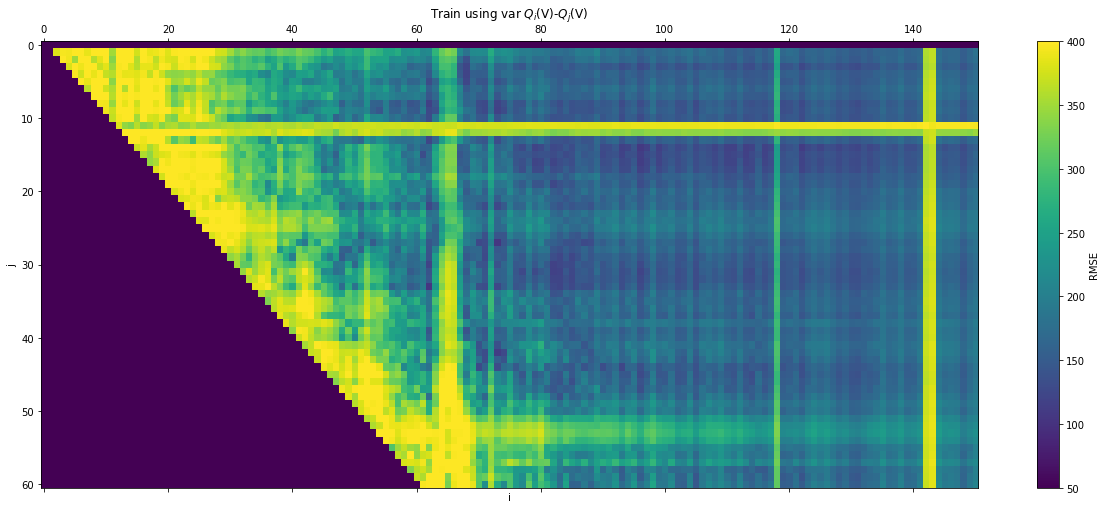

In [12]:
plt.figure(figsize=(21,8))
plt.matshow(mx_train, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(50,400)
plt.colorbar(label='RMSE')
plt.xlabel('i')
plt.ylabel('j')
plt.title('Train using var $Q_i$(V)-$Q_j$(V)')
plt.show()

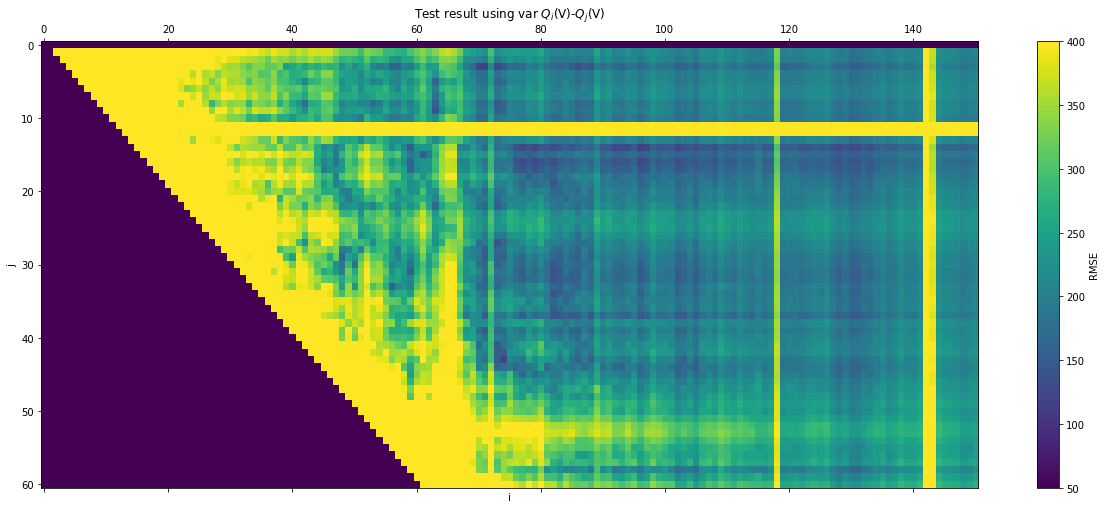

In [13]:
plt.figure(figsize=(21,8))
plt.matshow(mx_test, cmap=plt.cm.viridis,fignum=1,aspect='auto')
plt.clim(50,400)
plt.colorbar(label='RMSE')
plt.xlabel('i')
plt.ylabel('j')
plt.title('Test result using var $Q_i$(V)-$Q_j$(V)')
plt.show()